# Tehran Traffic Data

-----------------------------------------------------------------

## Setup
--------------------------------------------------

Let's setup Spark on your Colab environment.  Run the cell below!

In [1]:
!pip install pyspark
!pip install -U -q PyDrive
!apt-get install openjdk-8-jdk-headless -qq
!pip install pyspark-asyncactions

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 MB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 KB 15.6 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845512 sha256=13aa23415f0a94ea4f470ad20712648689708dc0af09ed299a523262b4ccf916
  Stored in directory: /root/.cache/pip/wheels/43/dc/11/ec201cd671da62fa9c5cc77078235e40722170ceba231d7598
Successfully built pyspark
Selecting previously unselected package openjdk-8-jre-headless:amd64.
(Reading database ... 129501 files and directories currently installed.)
Preparing to unpack .../openjdk-8-jre-headless_8u352-ga-1~20.04_amd64.deb ...
Unpacking openjdk-8-jre-headless:amd64 (8u352-ga-1~20.04) ...
Selecting previously unselected package openjdk-8-jdk-headless:amd64.
Preparing to unpack .../openjdk-8-jdk-headless_8u35

Now we authenticate a Google Drive client to processing data

**Make sure to follow the interactive instructions.**

In [2]:
from google.colab import drive
# This will prompt for authorization.
drive.mount('/content/drive')

Mounted at /content/drive


## Check and extract data
--------------------------------------------------

the cells above, extract data which is in '/content/drive/My Drive/Test' to /content/drive/My Drive/Test/Traffic.csv  

## Initializing Spark and read data
--------------------------------------------------

In [3]:
from pyspark.sql.functions import hour,dayofweek, count,floor,size
import pyspark.sql.functions as F


In [4]:
from pyspark import SparkContext, SparkConf 
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType,StructField, StringType, IntegerType,TimestampType
from pyspark.sql.functions import col,current_timestamp,to_date,hour,dayofweek
# import matplotlib.pyplot as plt
from itertools import combinations
from itertools import chain
import random
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import dayofyear
from pyspark.sql.functions import hour,dayofweek, count,floor
from pyspark.mllib.linalg.distributed import CoordinateMatrix, RowMatrix

import numpy as np

spark = SparkSession \
    .builder \
    .appName("MDA_2021") \
    .master("local[*]") \
    .config("spark.driver.memory", "15g") \
    .getOrCreate()
    
sc=spark.sparkContext

schema = StructType([ \
        StructField("DEVICE_CODE", IntegerType(), True), 
        StructField("SYSTEM_ID",IntegerType(),True), \
        StructField("ORIGINE_CAR_KEY",StringType(),True), \
        StructField("FINAL_CAR_KEY",StringType(),True), \
        StructField("CHECK_STATUS_KEY", IntegerType(), True), \
        StructField("COMPANY_ID", StringType(), True), \
        StructField("PASS_DAY_TIME", TimestampType(), True)
    ])

# Preprocessing

In [25]:
df=spark.read.csv('/content/drive/My Drive/Test/Data.csv',header=True,schema=schema)
df.show(1)

+-----------+---------+---------------+-------------+----------------+----------+-------------------+
|DEVICE_CODE|SYSTEM_ID|ORIGINE_CAR_KEY|FINAL_CAR_KEY|CHECK_STATUS_KEY|COMPANY_ID|      PASS_DAY_TIME|
+-----------+---------+---------------+-------------+----------------+----------+-------------------+
|   22010122|      284|       97955760|     64111706|               7|       161|2022-01-10 08:58:02|
+-----------+---------+---------------+-------------+----------------+----------+-------------------+
only showing top 1 row



In [26]:
# First we have to remove null values and then we remove any uncertainty regarding the car key. we don't want any unclear key or refined one.
df =df.filter((col("CHECK_STATUS_KEY") == 5) & (col("FINAL_CAR_KEY") != "null"))

# Histogram

In [6]:
# First we should load the dataset.
df=spark.read.csv('/content/drive/My Drive/Test/Data.csv',header=True,schema=schema)
df.show(1)

+-----------+---------+---------------+-------------+----------------+----------+-------------------+
|DEVICE_CODE|SYSTEM_ID|ORIGINE_CAR_KEY|FINAL_CAR_KEY|CHECK_STATUS_KEY|COMPANY_ID|      PASS_DAY_TIME|
+-----------+---------+---------------+-------------+----------------+----------+-------------------+
|   22010122|      284|       97955760|     64111706|               7|       161|2022-01-10 08:58:02|
+-----------+---------+---------------+-------------+----------------+----------+-------------------+
only showing top 1 row



In [7]:
# Removed all the cars with null value. and then we only want the clear car keys with no edits.
df = df.filter((col("CHECK_STATUS_KEY") == 5) & (col("FINAL_CAR_KEY") != "null"))

In [8]:
# Creating a unique key for each time of the day. Every day of the week is multiplied by 1000 and then summed with the hour of the day.
# Overall we would have 24x7 unique values. every value corresponds to a specific hour of a day.
df = df.withColumn('time', (dayofweek(df.PASS_DAY_TIME))*1000 + hour(df.PASS_DAY_TIME))
# Then we perform a groupby on FINAL_CAR_KEY and time columns and aggregate all 
gp_df = df.groupBy('FINAL_CAR_KEY', 'time').agg(F.collect_list(df["DEVICE_CODE"]), F.collect_list(df['PASS_DAY_TIME']))
gp_df.show(5, truncate=False)

+-------------+----+-------------------------+------------------------------------------+
|FINAL_CAR_KEY|time|collect_list(DEVICE_CODE)|collect_list(PASS_DAY_TIME)               |
+-------------+----+-------------------------+------------------------------------------+
|100000013    |5015|[100700881]              |[2022-01-13 15:15:40]                     |
|100000135    |6021|[900191]                 |[2022-01-14 21:29:06]                     |
|100000248    |1015|[100701267, 100701267]   |[2022-01-09 15:05:16, 2022-01-09 15:42:06]|
|100000399    |3007|[900222]                 |[2022-01-11 07:34:20]                     |
|100000497    |7007|[900151]                 |[2022-01-08 07:18:13]                     |
+-------------+----+-------------------------+------------------------------------------+
only showing top 5 rows



In [9]:
# Now we want to have only lists with 2 items to test the significance of the route.
adjcancents = gp_df.filter(size(col("collect_list(DEVICE_CODE)"))==2)

In [ ]:
adjcancents.count()

2653408

In [10]:
# Now performing groupby on list of device codes and now we're trying to see how often that route has appeared.
# For it to become signifanct we define a threshold. two cameras greater than this threshold should be adjacent.
adj = adjcancents.groupBy(col("collect_list(DEVICE_CODE)")).count().filter(col("count")> 800).orderBy(col("count").desc())
adj.show(10)


+-------------------------+-----+
|collect_list(DEVICE_CODE)|count|
+-------------------------+-----+
|         [900212, 900244]|39175|
|         [900244, 900212]|38279|
|         [631368, 900164]|17966|
|         [900164, 631368]|16221|
|      [631765, 100700820]|15205|
|     [100700804, 10070...|13851|
|         [900207, 631634]|12534|
|     [100700834, 10070...|12517|
|      [900236, 100700841]|12039|
|      [100700841, 900236]|11856|
+-------------------------+-----+
only showing top 10 rows



In [ ]:
# filtering the first query for more inspections
l = [[900212, 900244]]
adjcancents.filter((col("collect_list(DEVICE_CODE)")[0]== 900212) & (col("collect_list(DEVICE_CODE)")[1]== 900244)).show(10, truncate= False)

+-------------+----+-------------------------+------------------------------------------+
|FINAL_CAR_KEY|time|collect_list(DEVICE_CODE)|collect_list(PASS_DAY_TIME)               |
+-------------+----+-------------------------+------------------------------------------+
|10000448     |7021|[900212, 900244]         |[2022-01-08 21:07:16, 2022-01-08 21:08:38]|
|10005996     |1007|[900212, 900244]         |[2022-01-09 07:08:28, 2022-01-09 07:11:02]|
|10006268     |7006|[900212, 900244]         |[2022-01-08 06:47:42, 2022-01-08 06:50:11]|
|10010477     |6000|[900212, 900244]         |[2022-01-14 00:24:34, 2022-01-14 00:26:05]|
|10024793     |3019|[900212, 900244]         |[2022-01-11 19:34:00, 2022-01-11 19:35:22]|
|10028277     |1021|[900212, 900244]         |[2022-01-09 21:09:56, 2022-01-09 21:11:18]|
|10029799     |1020|[900212, 900244]         |[2022-01-09 20:47:07, 2022-01-09 20:48:22]|
|100301507    |1020|[900212, 900244]         |[2022-01-09 20:43:53, 2022-01-09 20:45:28]|
|100327542

In [ ]:
from pyspark.sql.functions import lit
# Adding a column of all zeros to the df
adjcancents = adjcancents.withColumn('count', lit(1))
adjcancents.show(10)

+-------------+----+-------------------------+---------------------------+-----+
|FINAL_CAR_KEY|time|collect_list(DEVICE_CODE)|collect_list(PASS_DAY_TIME)|count|
+-------------+----+-------------------------+---------------------------+-----+
|    100000248|1015|     [100701267, 10070...|       [2022-01-09 15:05...|    1|
|    100000712|2017|      [100700965, 900197]|       [2022-01-10 17:08...|    1|
|    100000809|7017|         [900149, 900215]|       [2022-01-08 17:02...|    1|
|     10000155|2013|         [900149, 900215]|       [2022-01-10 13:13...|    1|
|     10000155|7015|      [900235, 100700871]|       [2022-01-08 15:40...|    1|
|     10000188|5007|         [900191, 900218]|       [2022-01-13 07:25...|    1|
|     10000209|3019|         [900239, 900117]|       [2022-01-11 19:09...|    1|
|    100002243|5000|         [900151, 900101]|       [2022-01-13 00:56...|    1|
|    100002495|6020|      [100701100, 900223]|       [2022-01-14 20:46...|    1|
|    100002546|6017|        

In [ ]:
# Grouping by based on time column and then sum
nums = adjcancents.filter((col("collect_list(DEVICE_CODE)")[0]== 900212) & (col("collect_list(DEVICE_CODE)")[1]== 900244))\
    .groupBy(col("time"))\
    .sum()\
    .orderBy(col("time"))
nums.show(50, truncate=False)

+----+---------+----------+
|time|sum(time)|sum(count)|
+----+---------+----------+
|1000|142000   |142       |
|1001|51051    |51        |
|1002|40080    |40        |
|1003|17051    |17        |
|1004|72288    |72        |
|1005|331650   |330       |
|1006|665972   |662       |
|1007|353457   |351       |
|1008|24192    |24        |
|1009|19171    |19        |
|1010|11110    |11        |
|1011|9099     |9         |
|1012|27324    |27        |
|1013|12156    |12        |
|1014|406614   |401       |
|1015|502425   |495       |
|1016|499872   |492       |
|1017|332559   |327       |
|1018|232104   |228       |
|1019|306719   |301       |
|1020|379440   |372       |
|1021|316510   |310       |
|1022|316820   |310       |
|1023|259842   |254       |
|2000|270000   |135       |
|2001|138069   |69        |
|2002|44044    |22        |
|2003|36054    |18        |
|2004|90180    |45        |
|2005|533330   |266       |
|2006|846532   |422       |
|2007|766674   |382       |
|2008|56224    |28  

In [ ]:
x = [x[0] for x in nums.select('time').collect()]
y = [x[0] for x in nums.select("sum(count)").collect()]


In [ ]:
len(x)

168

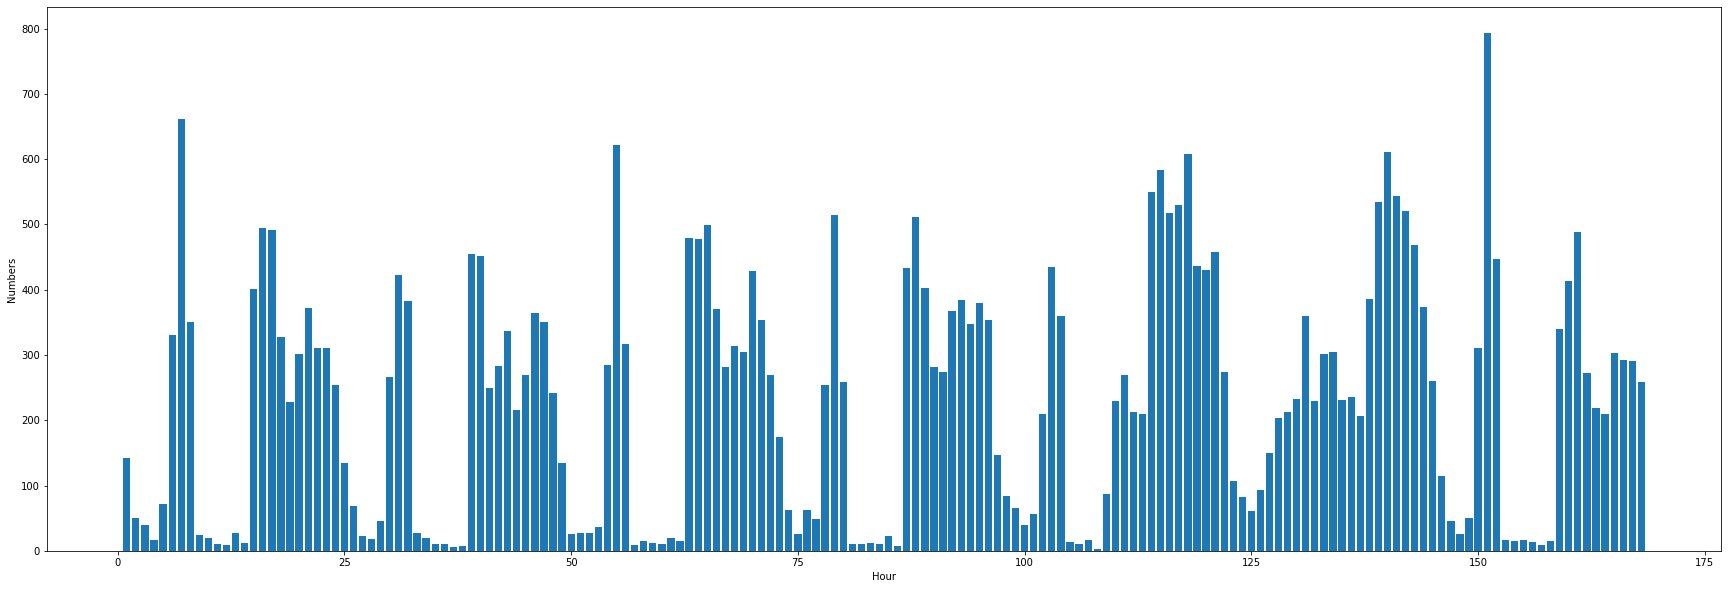

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (30, 10))
plt.bar(range(1,169), y)
plt.xlabel("Hour")
plt.ylabel("Numbers")
plt.show()

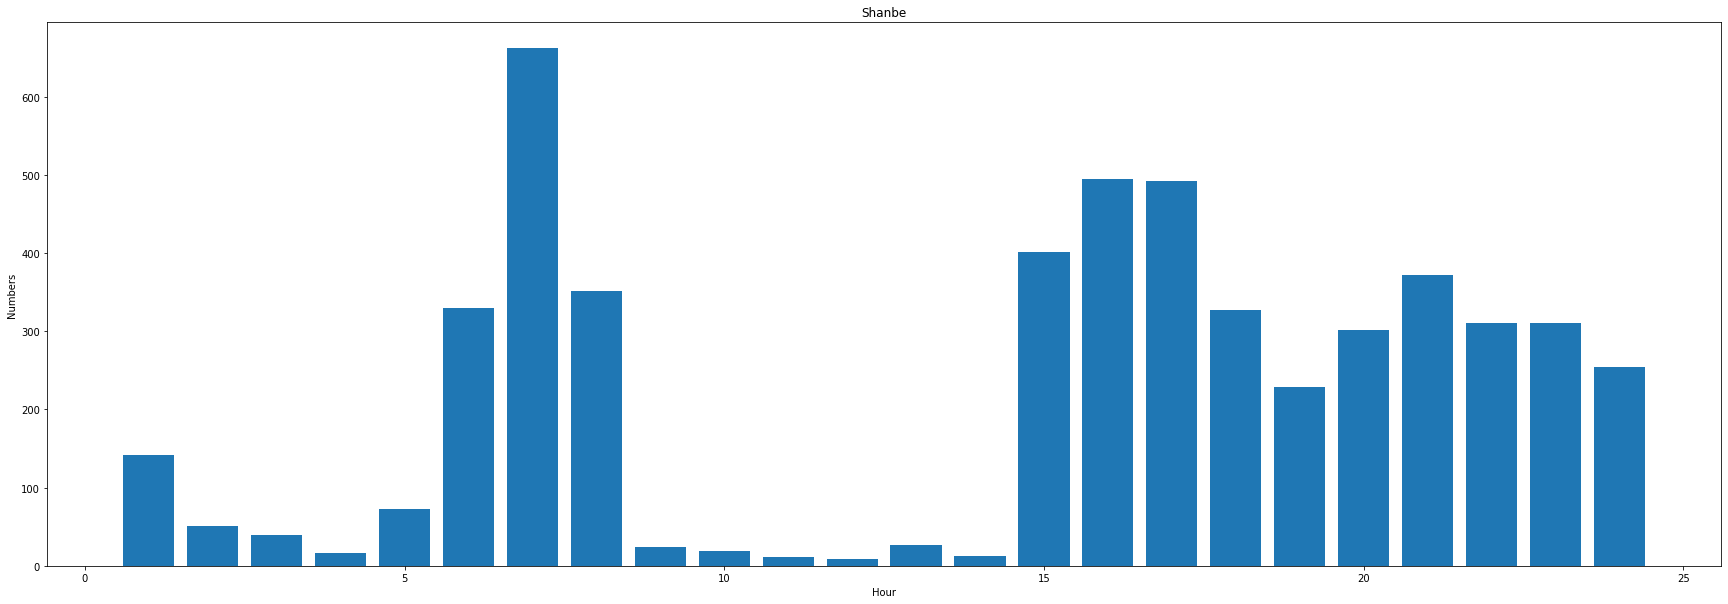

In [ ]:
fig = plt.figure(figsize = (30, 10))
plt.bar(range(1,25), y[:24])
plt.xlabel("Hour")
plt.ylabel("Numbers")
plt.title("Shanbe")
plt.show()

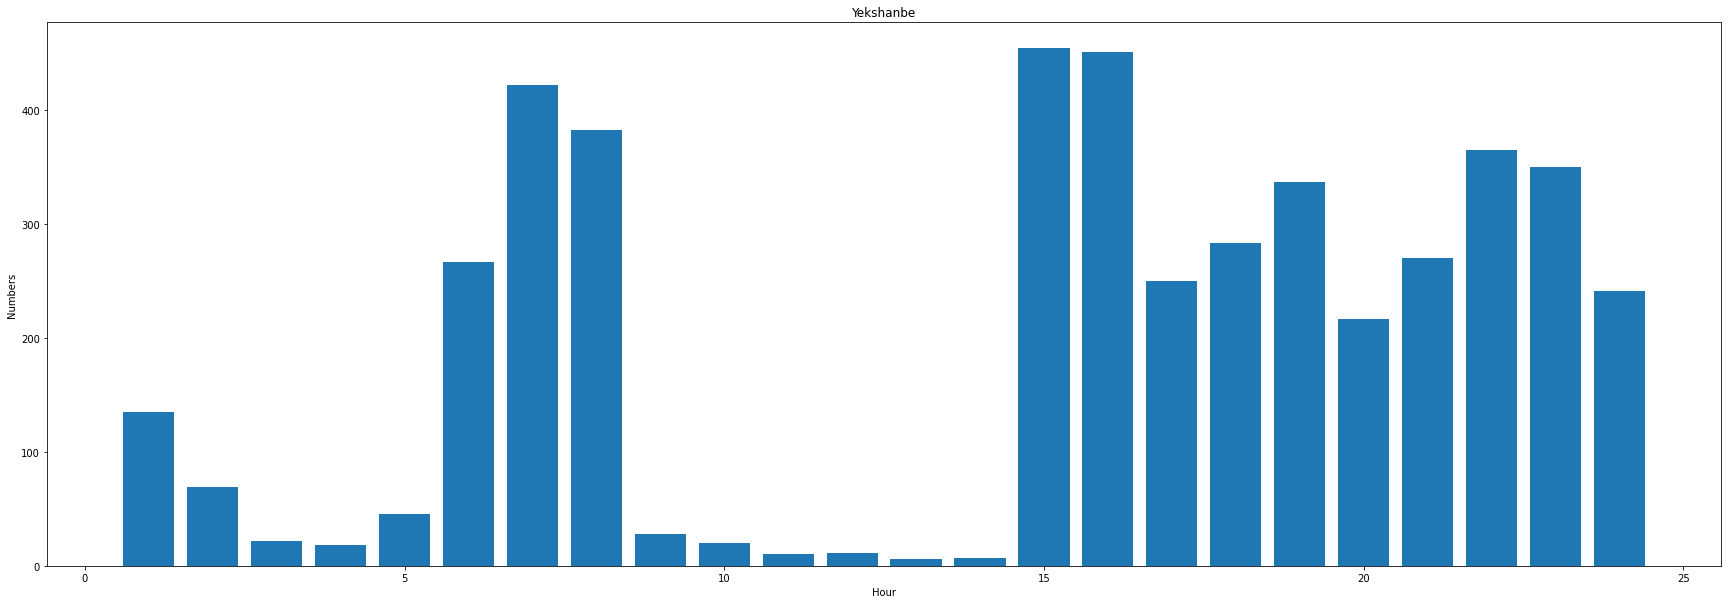

In [ ]:
fig = plt.figure(figsize = (30, 10))
plt.bar(range(1,25), y[24:48])
plt.title("Yekshanbe")
plt.xlabel("Hour")
plt.ylabel("Numbers")
plt.show()

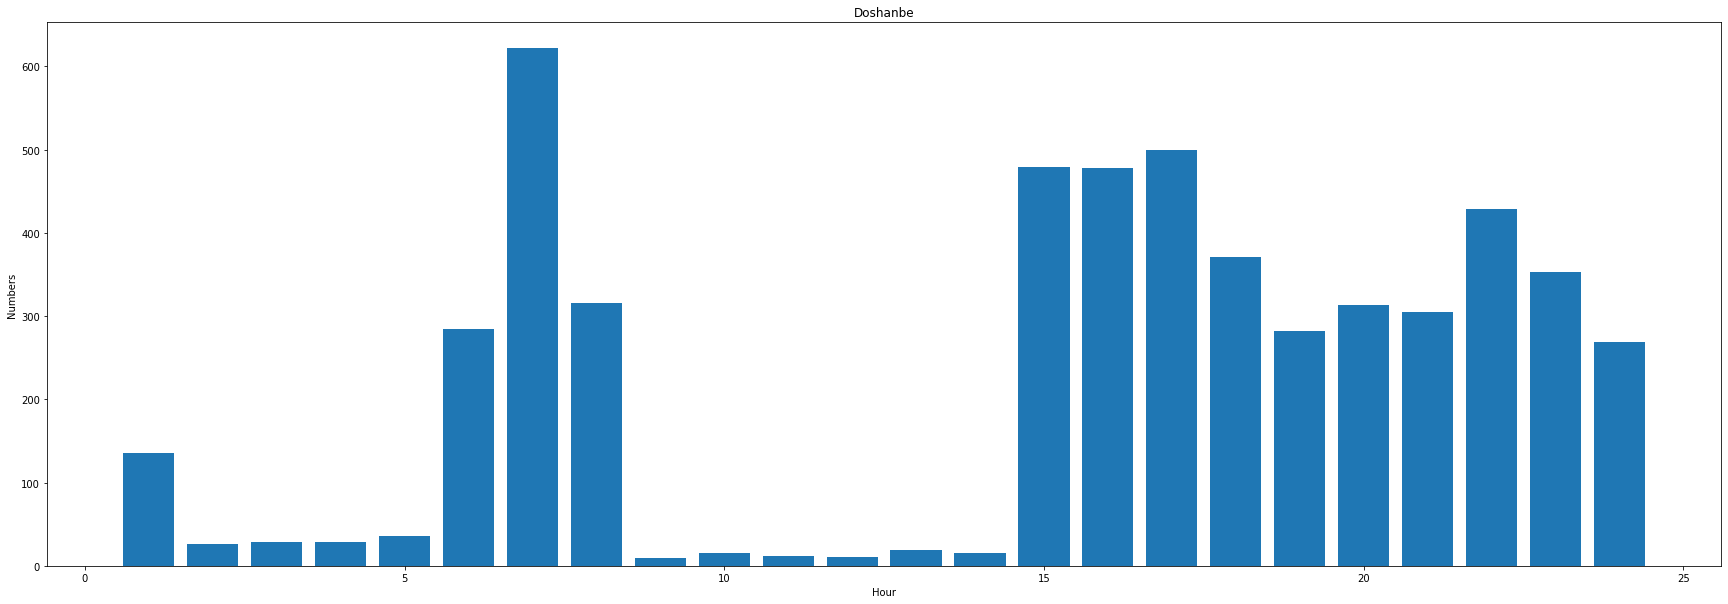

In [ ]:
fig = plt.figure(figsize = (30, 10))
plt.bar(range(1,25), y[48:72])
plt.title("Doshanbe")
plt.xlabel("Hour")
plt.ylabel("Numbers")
plt.show()

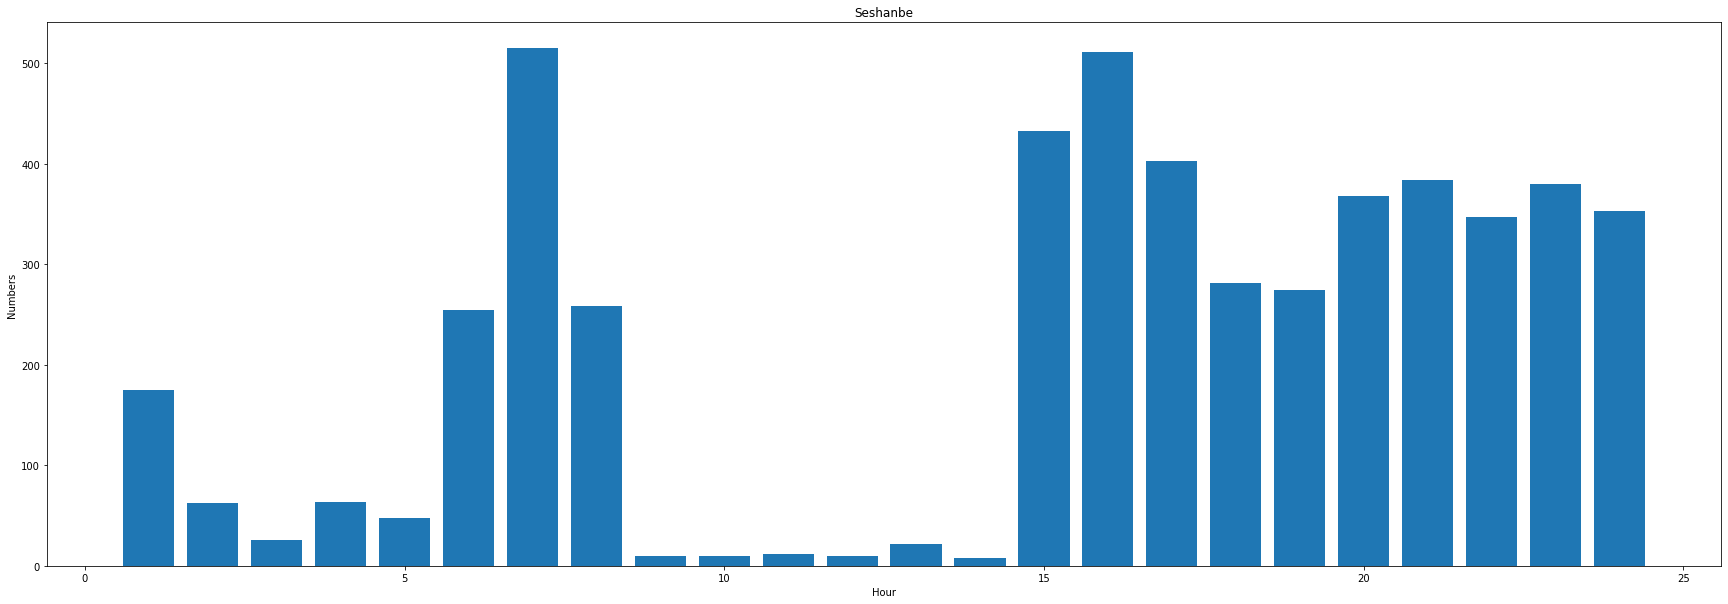

In [ ]:
fig = plt.figure(figsize = (30, 10))
plt.bar(range(1,25), y[72:96])
plt.title("Seshanbe")
plt.xlabel("Hour")
plt.ylabel("Numbers")
plt.show()

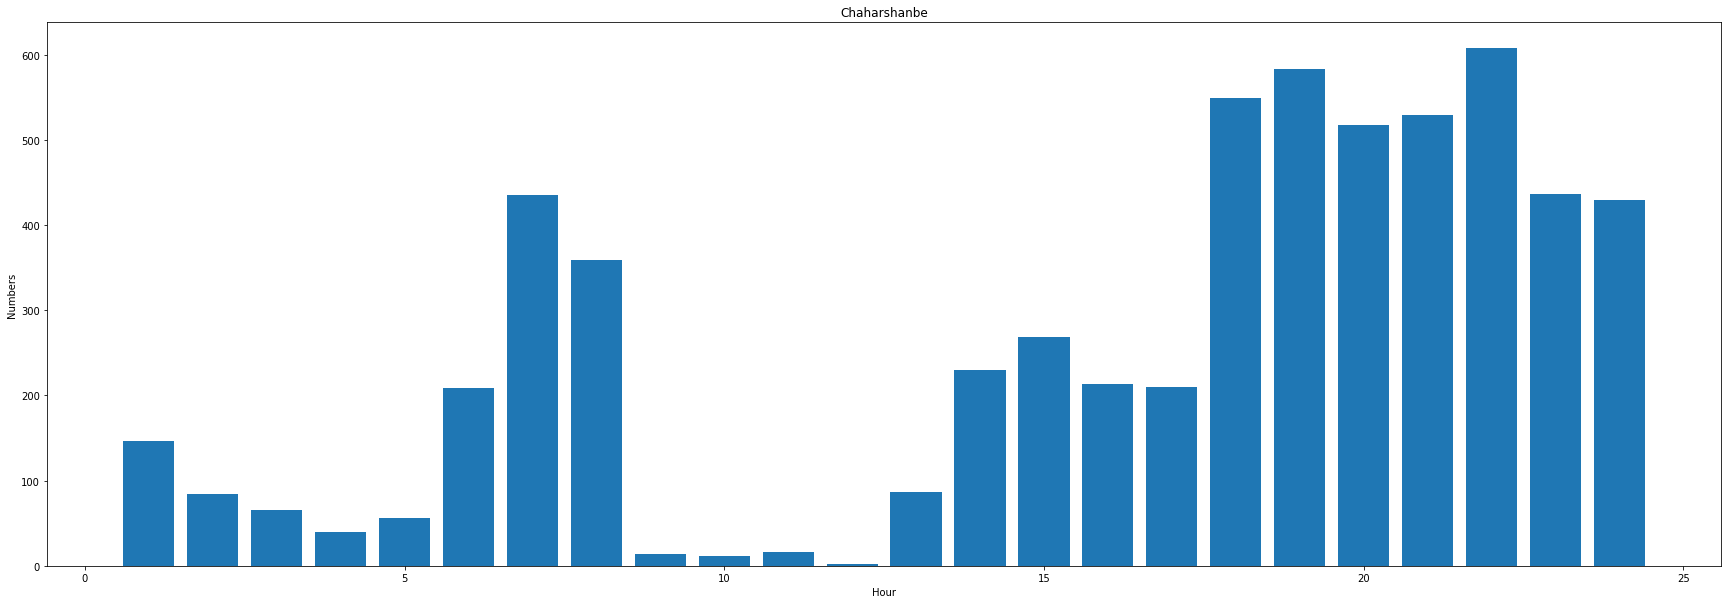

In [ ]:
fig = plt.figure(figsize = (30, 10))
plt.bar(range(1,25), y[96:96+24])
plt.title("Chaharshanbe")
plt.xlabel("Hour")
plt.ylabel("Numbers")
plt.show()

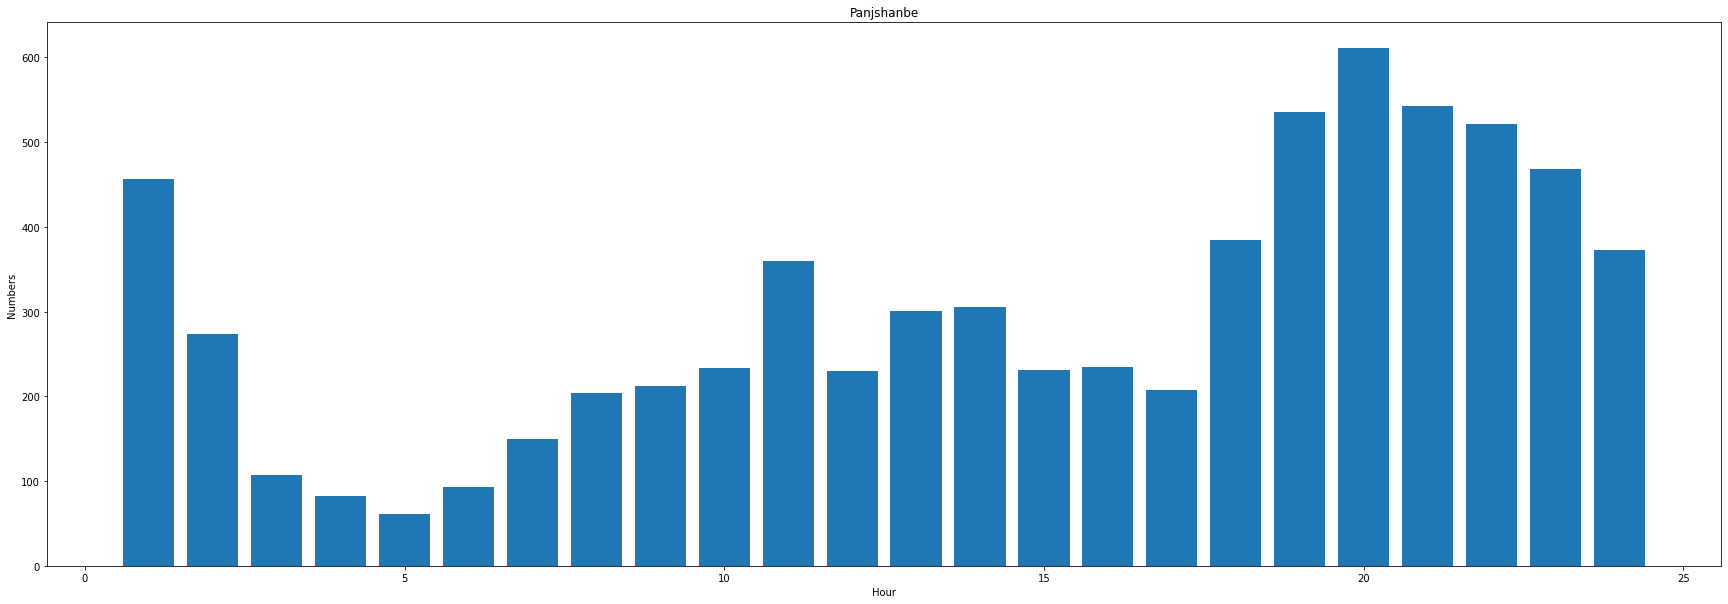

In [ ]:
fig = plt.figure(figsize = (30, 10))
plt.bar(range(1,25), y[96+24:96+24*2])
plt.title("Panjshanbe")
plt.xlabel("Hour")
plt.ylabel("Numbers")
plt.show()

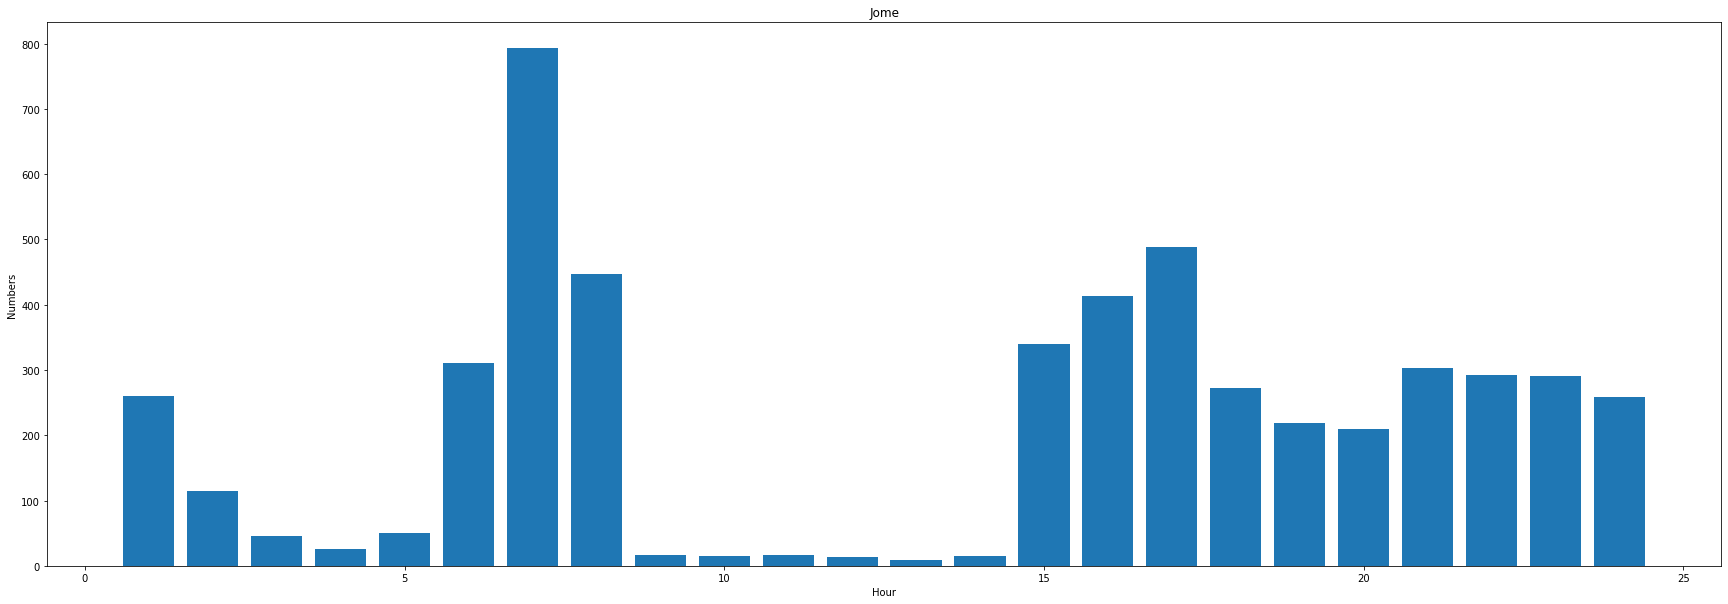

In [ ]:
fig = plt.figure(figsize = (30, 10))
plt.bar(range(1,25), y[144:168])
plt.title("Jome")
plt.xlabel("Hour")
plt.ylabel("Numbers")
plt.show()

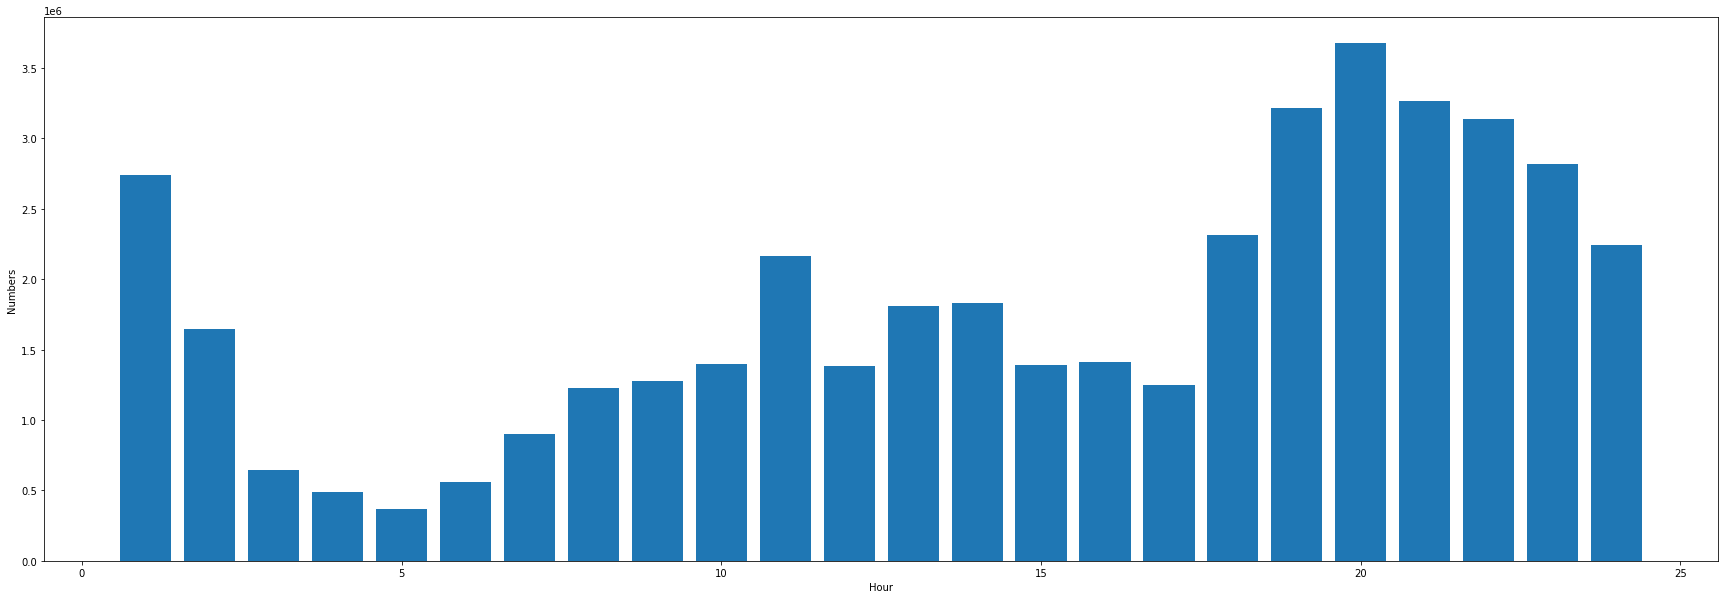

In [ ]:
fig = plt.figure(figsize = (30, 10))
plt.bar(range(1,25), y[120:144])
plt.xlabel("Hour")
plt.ylabel("Numbers")
plt.show()

# Frequent Itemset

In [11]:
# loading the dataset
df=spark.read.csv('/content/drive/My Drive/Test/Data.csv',header=True,schema=schema)
df.show(1)

+-----------+---------+---------------+-------------+----------------+----------+-------------------+
|DEVICE_CODE|SYSTEM_ID|ORIGINE_CAR_KEY|FINAL_CAR_KEY|CHECK_STATUS_KEY|COMPANY_ID|      PASS_DAY_TIME|
+-----------+---------+---------------+-------------+----------------+----------+-------------------+
|   22010122|      284|       97955760|     64111706|               7|       161|2022-01-10 08:58:02|
+-----------+---------+---------------+-------------+----------------+----------+-------------------+
only showing top 1 row



In [12]:
# Converting the dataframe to rdd type. Then extracting the day part from the pass time.
# then groupby FINAL_CAR_KEY and the day. In this way we want to treat every car at a given day as a transaction. 
# we make every transaction a set to remove duplicates and change it back to list for conveniance.
# at last, extracted the transaction from every list.
rdd = df.rdd.map(lambda x : ((x[3], x[-1].day),x[0]))\
    .groupByKey()\
    .map(lambda x : (x[0],sorted(list(set(list(x[1]))))))\
    .filter(lambda x : len(x[-1]) < 20)\
    .map(lambda x : x[-1])
rdd.take(10)

[[22010047],
 [103002,
  203902,
  206101,
  631357,
  631369,
  631763,
  631765,
  900149,
  900228,
  900234,
  900246,
  900266,
  100701059],
 [22010047, 22010057, 22010058],
 [100700820],
 [200101],
 [22010120, 22010134],
 [631368, 631765, 631829, 900164, 900214, 900222, 900228, 100701152],
 [900158, 100700881],
 [631633,
  900102,
  900144,
  900158,
  900208,
  900223,
  900225,
  900244,
  900273,
  100700857],
 [900155, 900224]]

In [13]:
# Now it's time to define the apriori algorithm
# I wrote a recursive function for apriori. 
def apriori(rdd, n, threshold):
    if n == 1:
        lst = rdd.flatMap(lambda x : x)\
        .map(lambda x : (x,1)).reduceByKey(lambda x, y : x+y)\
        .filter(lambda x : x[-1] > threshold)\
        .map(lambda x : ([x[0]],x[-1]))\
        .collect()
        return wrap(lst)
    else:
        dic = apriori(rdd, n-1, threshold)
        lst = rdd.flatMap(lambda x : list(combinations(x, n)))\
        .filter(lambda x : test_ng(x, dic, n-1))\
        .map(lambda x : (x,1)).reduceByKey(lambda x, y: x+y)\
        .filter(lambda x : x[-1] > threshold)\
        .collect()
        return wrap(lst)


In [14]:
# Some helper functions for our main apriori function.
def make_query(x):
    query = ""
    for i in x:
        query += str(i) + "|"
    return query[:-1]

def test_ng(x, dic, n):
    lst = list(combinations(x,n))
    for i in lst:
        if dic.get(make_query(i)) == None:
            return False
    return True

def wrap(x): 
    dic = {}
    for item in x:
        query = ""
        for i in item[0]:
            query += str(i) + "|"
        query = query[:-1]
        dic[query] = item[-1]

    return dic


In [15]:
freq_2 = apriori(rdd, 2, 1000)
freq_2

{'203902|900246': 2776,
 '631357|631765': 5157,
 '631368|900164': 81434,
 '900214|900228': 16935,
 '900222|900228': 19550,
 '631633|900225': 12051,
 '900102|900208': 5119,
 '900102|900244': 47351,
 '900223|900273': 4048,
 '900225|900273': 22207,
 '212802|900246': 7763,
 '631363|631829': 20396,
 '631363|900233': 2078,
 '900113|900139': 4475,
 '900212|900226': 9023,
 '900156|100701090': 19183,
 '100701090|100701092': 13330,
 '205201|22009971': 28600,
 '204401|900191': 2911,
 '900101|900191': 6451,
 '631355|100700841': 1840,
 '631634|900222': 58364,
 '22010110|22010112': 8667,
 '22010111|22010139': 1018,
 '631757|631765': 2660,
 '900164|100700820': 67173,
 '900222|100700820': 8583,
 '145|900101': 18487,
 '900101|22010117': 1159,
 '900142|900214': 4007,
 '900155|900167': 3308,
 '900212|900214': 9503,
 '900226|900228': 6299,
 '900253|22009971': 2782,
 '900167|100700857': 18650,
 '900191|22010117': 5157,
 '900152|900244': 31469,
 '900244|100701090': 4609,
 '900244|100701096': 5672,
 '112|200

In [21]:
freq_3 = apriori(rdd, 3, 1000)
freq_3

{'631763|900228|900246': 1497,
 '631765|900222|900228': 1060,
 '631633|900225|900273': 1648,
 '205802|900233|900234': 12155,
 '631363|900226|900246': 2819,
 '631361|900226|900244': 1251,
 '900113|900212|900244': 2564,
 '900226|900244|900259': 1597,
 '205201|900191|22009971': 3123,
 '175|900101|900191': 1561,
 '631633|900142|900222': 5696,
 '631633|900142|900244': 40913,
 '631634|900141|900244': 1869,
 '900141|900222|900244': 1706,
 '900142|900222|100700841': 1036,
 '900222|900244|100700841': 2613,
 '117|900234|900266': 2649,
 '212802|900234|22009971': 1197,
 '135|900167|100700857': 4556,
 '631363|900141|100700881': 1457,
 '900101|900152|900212': 2321,
 '900101|900152|900244': 1793,
 '900101|900152|100701096': 1224,
 '900101|900212|900224': 1015,
 '900142|900199|900212': 2205,
 '900142|900199|100701090': 1451,
 '900142|900244|900245': 4401,
 '900152|900212|100700853': 16591,
 '900212|900244|900245': 9178,
 '631829|900102|900222': 1635,
 '100|900246|900273': 2712,
 '631367|900212|900244'

In [ ]:
freq_6 = apriori(rdd, 6, 1000)
freq_6

{'631634|900142|900202|900212|900244|100700853': 1148,
 '631633|631634|900142|900212|900244|100700853': 2738,
 '631634|900142|900152|900212|900244|100700853': 1009,
 '631634|900142|900212|900222|900244|100700853': 1022}

In [ ]:
freq_5 = apriori(rdd, 5, 1000)
freq_5

{'631634|900212|900213|900244|900264': 1726,
 '631634|900152|900212|900244|100700853': 1539,
 '631633|900212|900227|900244|900269': 1110,
 '631633|631634|900212|900236|900244': 1222,
 '631633|900142|900152|900212|900244': 1754,
 '231|900212|900236|900244|900255': 1176,
 '900142|900193|900212|900244|100700853': 2241,
 '631633|631634|900212|900213|900244': 2220,
 '631633|900212|900213|900244|900264': 1988,
 '631633|631634|900207|900212|900244': 1647,
 '900142|900212|900244|900273|100700853': 1276,
 '900102|900142|900152|900212|900244': 1172,
 '631633|900152|900212|900244|100700853': 1398,
 '631634|900142|900212|900244|100700853': 6752,
 '631633|631634|900212|900222|900244': 2232,
 '900212|900227|900244|900259|900269': 1479,
 '900142|900212|900225|900244|100700853': 1190,
 '900199|900212|900213|900244|900264': 1023,
 '631634|900142|900212|900222|900244': 1497,
 '900142|900207|900212|900244|100700853': 1014,
 '631633|900212|900222|900244|100700853': 1306,
 '205802|212802|900215|900233|9002

In [ ]:
freq_4 = apriori(rdd, 4, 1000)
freq_4

{'900212|900244|100700839|100700841': 1076,
 '900185|900241|900242|100700864': 2094,
 '119|123|900266|100700804': 2503,
 '123|209103|900266|100700804': 1486,
 '205201|205202|22009971|22009972': 1046,
 '900225|900246|900268|900269': 1956,
 '900142|900212|900273|100700853': 5249,
 '900102|900142|900212|900244': 7465,
 '900102|900212|900244|900246': 2134,
 '230204|631368|900164|100700820': 3164,
 '103001|900218|22009971|22009972': 1108,
 '900142|900212|900225|100700853': 1997,
 '900212|900244|900259|100700853': 2617,
 '631634|900202|900212|900244': 5510,
 '631368|900164|900212|900244': 2791,
 '114|231|900236|100700841': 1298,
 '900212|900225|900244|900269': 3744,
 '631633|631634|900202|900207': 2448,
 '631633|631634|900212|900273': 1535,
 '900142|900207|900212|100700853': 1382,
 '175|900191|900218|100700864': 4675,
 '175|205802|900191|900218': 1523,
 '175|205802|900191|900234': 1196,
 '900223|900225|900268|100701100': 3179,
 '900101|900211|900212|900244': 1159,
 '900212|900225|900268|1007

# CF ALS Algorithm

In [ ]:
# Loading dataset
df=spark.read.csv('/content/drive/My Drive/Test/Data.csv',header=True,schema=schema)
df.show(1)

+-----------+---------+---------------+-------------+----------------+----------+-------------------+
|DEVICE_CODE|SYSTEM_ID|ORIGINE_CAR_KEY|FINAL_CAR_KEY|CHECK_STATUS_KEY|COMPANY_ID|      PASS_DAY_TIME|
+-----------+---------+---------------+-------------+----------------+----------+-------------------+
|   22010122|      284|       97955760|     64111706|               7|       161|2022-01-10 08:58:02|
+-----------+---------+---------------+-------------+----------------+----------+-------------------+
only showing top 1 row



In [ ]:
# Creating a unique key for each time of the day. Every day of the week is multiplied by 1000 and then summed with the hour of the day.
# Overall we would have 24x7 unique values. every value corresponds to a specific hour of a day.
df = df.withColumn('time', (dayofweek(df.PASS_DAY_TIME))*1000 + hour(df.PASS_DAY_TIME))
df = df.groupBy('DEVICE_CODE', 'time').count()
df.show(5)

+-----------+----+-----+
|DEVICE_CODE|time|count|
+-----------+----+-----+
|     205201|2009|  734|
|     631782|2010|   28|
|     900234|5020| 2018|
|     900161|7001|   19|
|     206701|7000|  156|
+-----------+----+-----+
only showing top 5 rows



In [ ]:
# Splitting dataframe into train and test. because we want to train ALS model to predict missing values in the recommender matrix.
train, test = df.randomSplit([0.75, 0.25])

In [ ]:
# Define ALS with the specified parameters.
als = ALS(
    maxIter = 8, 
    regParam = 0.02, 
    userCol = 'DEVICE_CODE', 
    itemCol = 'time', 
    ratingCol = 'count',
    coldStartStrategy= 'drop')

model = als.fit(train)

In [ ]:
# Now predict the model via the test set.
predictions = model.transform(test)
predictions.show(5)
evaluator = RegressionEvaluator(
    metricName = 'rmse', 
    labelCol = 'count',
    predictionCol = 'prediction'
    )
rmse = evaluator.evaluate(predictions)
print(rmse)

+-----------+----+-----+----------+
|DEVICE_CODE|time|count|prediction|
+-----------+----+-----+----------+
|        100|1002|   47| 57.263245|
|        100|1015|  732|  794.1469|
|        100|1018| 1026| 929.79944|
|        100|2019|  991| 863.61505|
|        100|2022|  445| 476.46796|
+-----------+----+-----+----------+
only showing top 5 rows

102.80522589258547


In [ ]:
# Here is the hidden latent factos. We extracted the featurs.
model.userFactors.show(10, truncate = False)

+------+------------------------------------------------------------------------------------------------------------------------------------------+
|id    |features                                                                                                                                  |
+------+------------------------------------------------------------------------------------------------------------------------------------------+
|100   |[-0.5601204, -0.17483932, 0.8828793, 0.95169294, -0.6620351, 1.8563546, 2.5353675, -2.773161, 1.0058646, 0.19319953]                      |
|110   |[-0.11822389, -0.07011985, 0.17605148, -0.06813672, -0.1649506, 0.050261877, 0.15453278, -0.27648336, -0.006745793, -0.16796225]          |
|120   |[-0.037948184, -0.014022691, 0.09033042, -0.05635558, -0.057572987, 0.19148272, 0.23801516, -0.15656789, -0.045216024, 0.12750587]        |
|130   |[0.0018154873, 0.006461712, 0.029056486, -0.018640565, 0.0016985423, 0.07948152, 0.021564297, -0.0838344

In [ ]:
factors = model.userFactors.collect()
factors

In [ ]:
query = model.userFactors.filter(col("id") == 200501 ).collect()

In [ ]:
# This is the features of the query 
query_features = np.array(query[0][1])

In [ ]:
# Now we define euclidean distance function to compute the euclidean distance between two arrays
def euclidean_distance(query, factors):
    euclidean = {}
    for fac in factors:
        dist = np.linalg.norm(query - np.array(fac[1]))
        euclidean[fac[0]] = dist
    return sorted(euclidean.items(), key=lambda x:x[1], reverse = True)

euclidean_distance(query_features, factors)[-10:]

[(107, 0.1681019302279933),
 (202201, 0.16757415813717513),
 (164, 0.166944674008158),
 (204701, 0.1583428035132431),
 (200801, 0.15646673474528006),
 (900115, 0.14805679380285164),
 (201901, 0.14044299962922432),
 (167, 0.1294372211539918),
 (631348, 0.12055280227172104),
 (200501, 0.0)]

In [ ]:
# Now we define cosine distance function to compute the cosine distance between two arrays
def cosine_distance(query, factors):
    cosine = {}
    for fac in factors:
        dist = 1 - (query @ np.array(fac[1]).T) / (np.linalg.norm(query)*np.linalg.norm(np.array(fac[1])))
        cosine[fac[0]] = dist
    return sorted(cosine.items(), key=lambda x:x[1], reverse = True)

cosine_distance(query_features, factors)[-10:]

[(203701, 0.10893682206686972),
 (167, 0.10741107175211329),
 (631783, 0.10494092770470453),
 (900145, 0.10492531794989235),
 (149, 0.10359445987944893),
 (631348, 0.1025542787486543),
 (100701136, 0.09933974753897556),
 (202901, 0.09743373607495032),
 (103, 0.07624666082251785),
 (200501, 0.0)]

In [ ]:
pred_x_1 = [x for x in predictions.filter(predictions.DEVICE_CODE == 900234).select('time').collect()]
pred_y_1 = [x for x in predictions.filter(predictions.DEVICE_CODE == 900234).select('prediction').collect()]
real_y_1 = [x for x in predictions.filter(predictions.DEVICE_CODE == 900234).select('count').collect()]


In [ ]:
fig = plt.figure(figsize = (30, 10))
plt.plot(range(1,43), pred_y_1, color = 'blue')
plt.plot(range(1,43), real_y_1, color = 'red')
plt.ylabel('count')
plt.xlabel('time')

plt.show()

In [ ]:
pred_x_2 = [x for x in predictions.filter(predictions.DEVICE_CODE == 206701).select('time').collect()]
pred_y_2 = [x for x in predictions.filter(predictions.DEVICE_CODE == 206701).select('prediction').collect()]
real_y_2 = [x for x in predictions.filter(predictions.DEVICE_CODE == 206701).select('count').collect()]


In [ ]:
fig = plt.figure(figsize = (30, 10))
plt.plot(range(1,len(pred_y_2)+1), pred_y_2, color = 'blue')
plt.plot(range(1,len(pred_y_2)+1), real_y_2, color = 'red')
plt.ylabel('count')
plt.xlabel('time')

plt.show()

In [ ]:
pred_x_3 = [x for x in predictions.filter(predictions.DEVICE_CODE == 100).select('time').collect()]
pred_y_3 = [x for x in predictions.filter(predictions.DEVICE_CODE == 100).select('prediction').collect()]
real_y_3 = [x for x in predictions.filter(predictions.DEVICE_CODE == 100).select('count').collect()]


In [ ]:
fig = plt.figure(figsize = (30, 10))
plt.plot(range(1,len(pred_y_3)+1), pred_y_3, color = 'blue')
plt.plot(range(1,len(pred_y_3)+1), real_y_3, color = 'red')
plt.ylabel('count')
plt.xlabel('time')

plt.show()

In [ ]:
# Now we do it with smaller vectors first approach is to use 7*6 vector

df=spark.read.csv('/content/drive/My Drive/Test/Data.csv',header=True,schema=schema)
df.show(1)

+-----------+---------+---------------+-------------+----------------+----------+-------------------+
|DEVICE_CODE|SYSTEM_ID|ORIGINE_CAR_KEY|FINAL_CAR_KEY|CHECK_STATUS_KEY|COMPANY_ID|      PASS_DAY_TIME|
+-----------+---------+---------------+-------------+----------------+----------+-------------------+
|   22010122|      284|       97955760|     64111706|               7|       161|2022-01-10 08:58:02|
+-----------+---------+---------------+-------------+----------------+----------+-------------------+
only showing top 1 row



In [ ]:
df = df.withColumn('time_gp', (dayofweek(df.PASS_DAY_TIME))*1000 + floor((hour(df.PASS_DAY_TIME) / 4)))
df = df.groupBy('DEVICE_CODE', 'time_gp').count()
df.show(5)

+-----------+-------+-----+
|DEVICE_CODE|time_gp|count|
+-----------+-------+-----+
|     900113|   7000|  277|
|   22010121|   7000|   44|
|     213401|   7001|  556|
|     631763|   7001| 1070|
|     631369|   7001| 1047|
+-----------+-------+-----+
only showing top 5 rows



In [ ]:
train, test = df.randomSplit([0.75, 0.25])
als = ALS(
    maxIter = 8, 
    regParam = 0.02, 
    userCol = 'DEVICE_CODE', 
    itemCol = 'time_gp', 
    ratingCol = 'count',
    coldStartStrategy= 'drop')

model = als.fit(train)

In [ ]:
predictions = model.transform(test)
predictions.show(5)
evaluator = RegressionEvaluator(
    metricName = 'rmse', 
    labelCol = 'count',
    predictionCol = 'prediction'
    )
rmse = evaluator.evaluate(predictions)
print(rmse)

+-----------+-------+-----+----------+
|DEVICE_CODE|time_gp|count|prediction|
+-----------+-------+-----+----------+
|        100|   1005| 2381|  2258.242|
|        100|   2004| 3491|  3220.355|
|        100|   3001| 1549| 1538.0457|
|        100|   5000|  478|  559.6983|
|        100|   5001|  966|  955.2379|
+-----------+-------+-----+----------+
only showing top 5 rows

572.6891595065725


In [ ]:
factors = model.userFactors.collect()
query = model.userFactors.filter(col("id") == 200501 ).collect()
query_features = np.array(query[0][1])


In [ ]:
cosine_distance(query_features, factors)[-10:]


[(900148, 0.05276827321100963),
 (631781, 0.04424501601093356),
 (200901, 0.029499515918998687),
 (204401, 0.029488706627786465),
 (22010073, 0.027965473573862476),
 (200801, 0.027802307324674702),
 (631783, 0.025114768928042652),
 (205301, 0.022670162650854087),
 (121, 0.02086982130491477),
 (200501, -2.220446049250313e-16)]

In [ ]:
euclidean_distance(query_features, factors)[-10:]

[(204701, 0.22802293746461477),
 (121, 0.2106554541383601),
 (202201, 0.20757217302313952),
 (126, 0.20664748794257684),
 (207201, 0.20401747254533517),
 (631348, 0.19223535698121094),
 (204501, 0.19194344271456287),
 (205301, 0.15106326986075613),
 (200801, 0.10146336281870612),
 (200501, 0.0)]

In [ ]:
pred_x_1 = [x for x in predictions.filter(predictions.DEVICE_CODE == 900234).select('time_gp').collect()]
pred_y_1 = [x for x in predictions.filter(predictions.DEVICE_CODE == 900234).select('prediction').collect()]
real_y_1 = [x for x in predictions.filter(predictions.DEVICE_CODE == 900234).select('count').collect()]


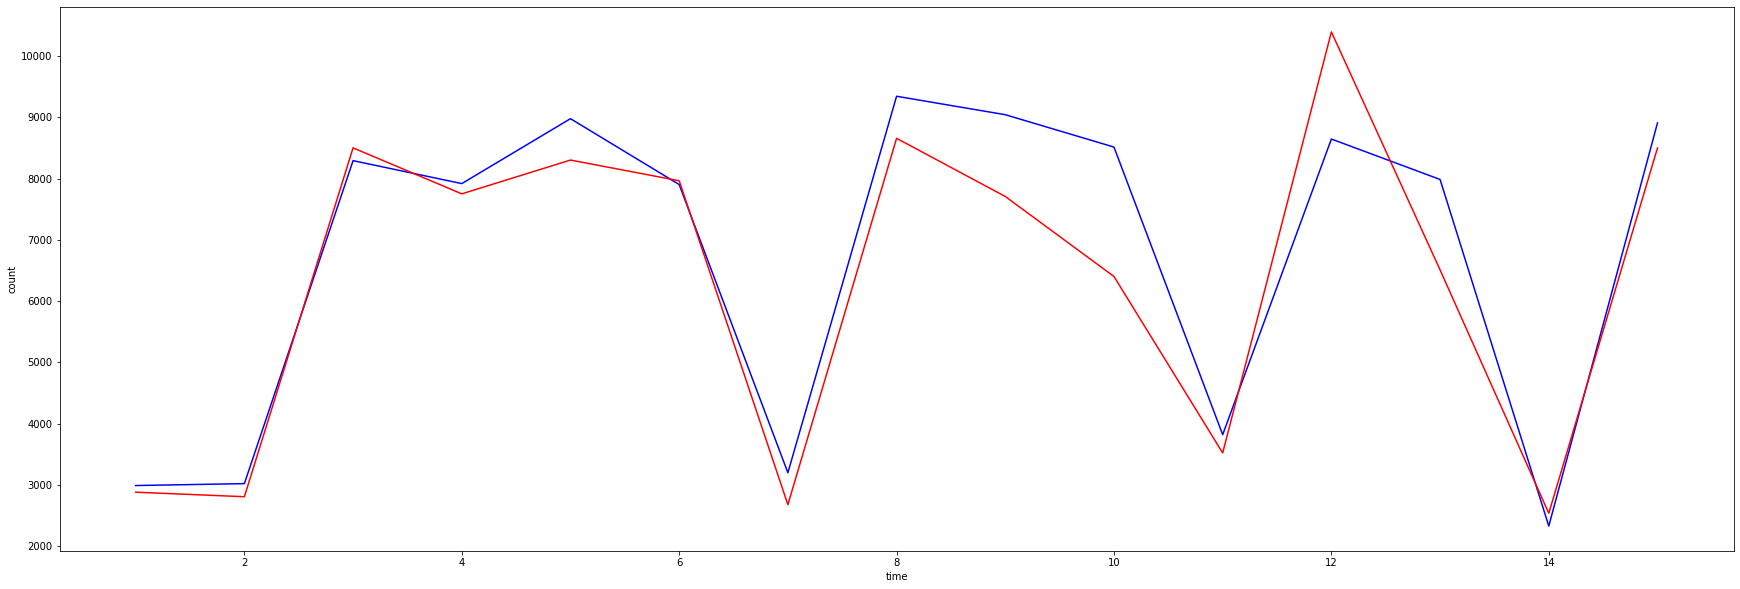

In [ ]:
fig = plt.figure(figsize = (30, 10))
plt.plot(range(1,len(pred_y_1)+1), pred_y_1, color = 'blue')
plt.plot(range(1,len(pred_y_1)+1), real_y_1, color = 'red')
plt.ylabel('count')
plt.xlabel('time')

plt.show()

In [ ]:
pred_x_2 = [x for x in predictions.filter(predictions.DEVICE_CODE == 206701).select('time_gp').collect()]
pred_y_2 = [x for x in predictions.filter(predictions.DEVICE_CODE == 206701).select('prediction').collect()]
real_y_2 = [x for x in predictions.filter(predictions.DEVICE_CODE == 206701).select('count').collect()]

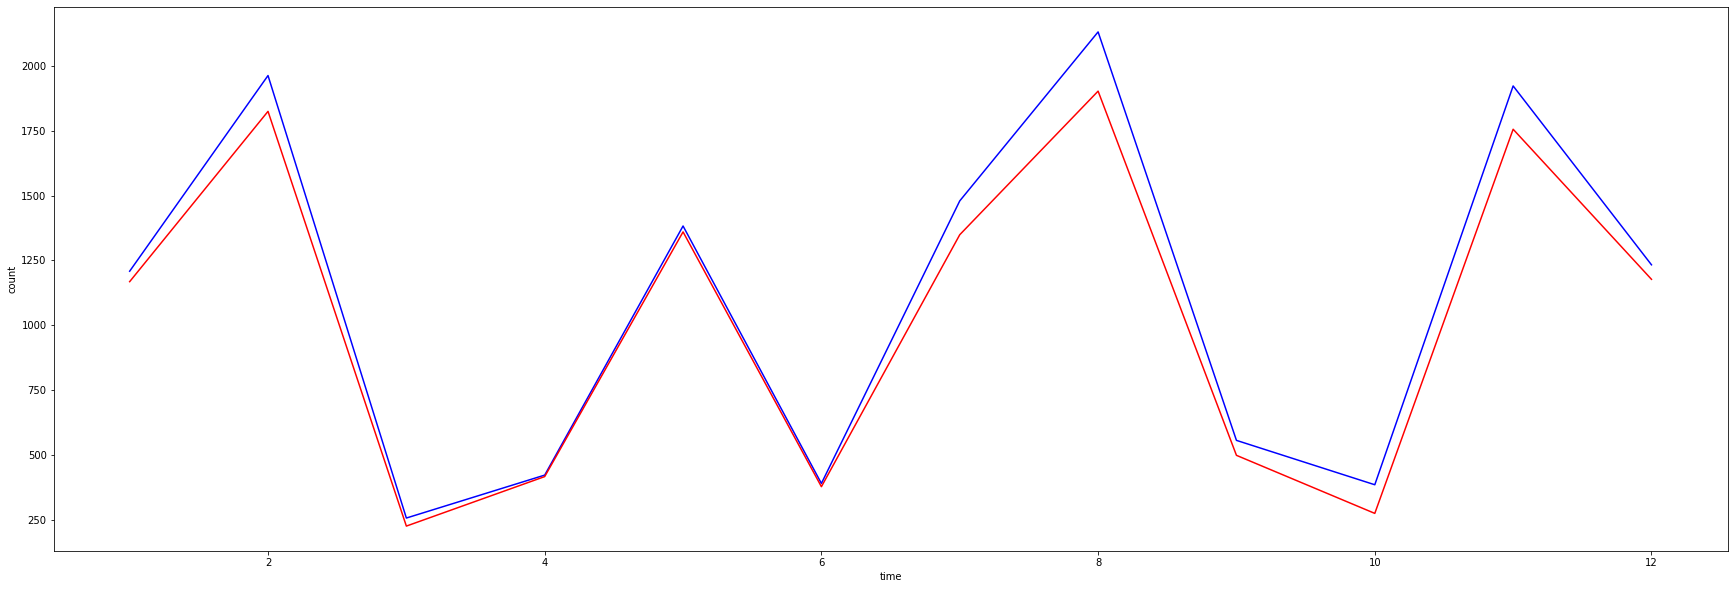

In [ ]:
fig = plt.figure(figsize = (30, 10))
plt.plot(range(1,len(pred_y_2)+1), pred_y_2, color = 'blue')
plt.plot(range(1,len(pred_y_2)+1), real_y_2, color = 'red')
plt.ylabel('count')
plt.xlabel('time')

plt.show()

In [ ]:
pred_x_3 = [x for x in predictions.filter(predictions.DEVICE_CODE == 100).select('time_gp').collect()]
pred_y_3 = [x for x in predictions.filter(predictions.DEVICE_CODE == 100).select('prediction').collect()]
real_y_3 = [x for x in predictions.filter(predictions.DEVICE_CODE == 100).select('count').collect()]


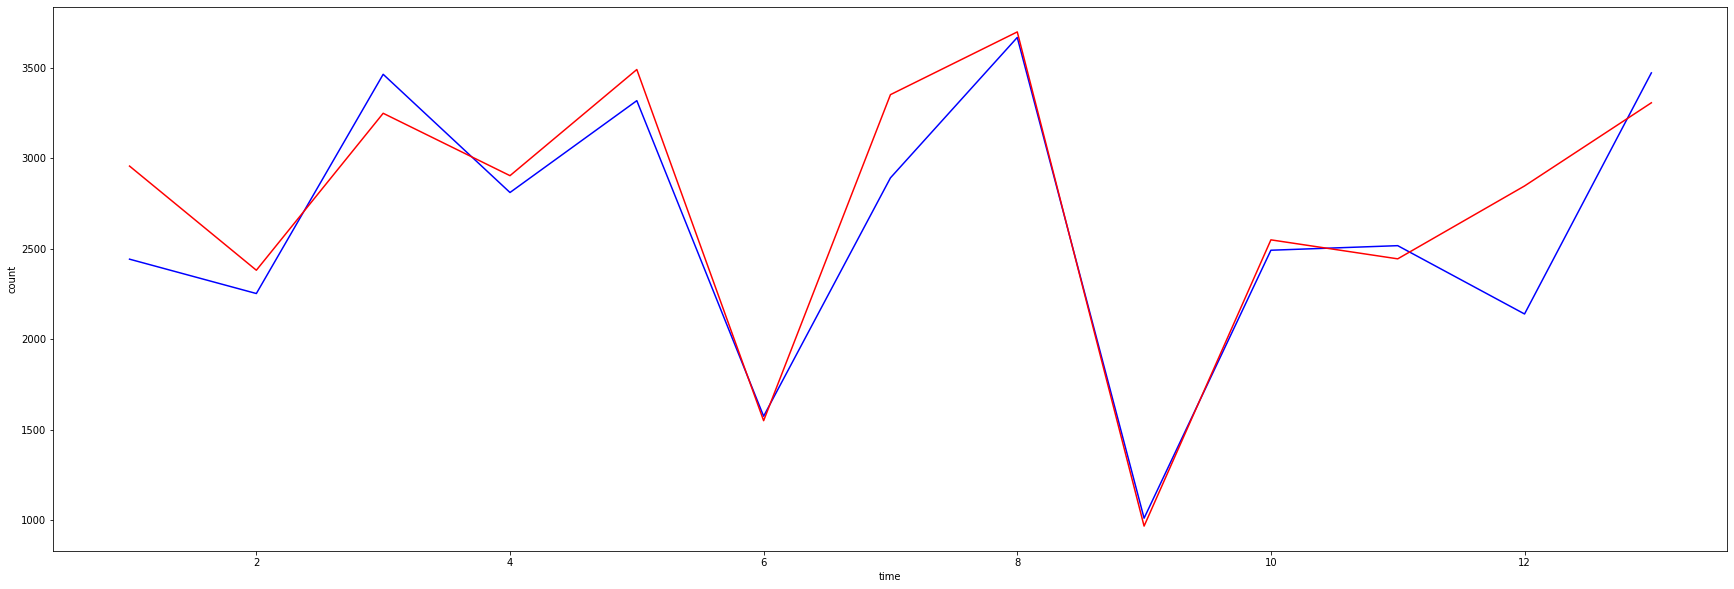

In [ ]:
fig = plt.figure(figsize = (30, 10))
plt.plot(range(1,len(pred_y_3)+1), pred_y_3, color = 'blue')
plt.plot(range(1,len(pred_y_3)+1), real_y_3, color = 'red')
plt.ylabel('count')
plt.xlabel('time')

plt.show()

# SVD

In [ ]:
df=spark.read.csv('/content/drive/My Drive/Test/Data.csv',header=True,schema=schema)
df.show(1)

+-----------+---------+---------------+-------------+----------------+----------+-------------------+
|DEVICE_CODE|SYSTEM_ID|ORIGINE_CAR_KEY|FINAL_CAR_KEY|CHECK_STATUS_KEY|COMPANY_ID|      PASS_DAY_TIME|
+-----------+---------+---------------+-------------+----------------+----------+-------------------+
|   22010122|      284|       97955760|     64111706|               7|       161|2022-01-10 08:58:02|
+-----------+---------+---------------+-------------+----------------+----------+-------------------+
only showing top 1 row



In [ ]:
cars = df.groupBy('FINAL_CAR_KEY').count()
cars.show(10)


+-------------+-----+
|FINAL_CAR_KEY|count|
+-------------+-----+
|     33960503|   18|
|     33862247|   44|
|      8980375|   17|
|      8984313|   27|
|      9835643|   18|
|      9845379|    3|
|     21952017|    2|
|     48411541|    6|
|      8053559|   29|
|     10017297|    8|
+-------------+-----+
only showing top 10 rows



In [ ]:
cars_list = cars.filter(cars['count'] < 1000).sort('count', ascending=False).select('FINAL_CAR_KEY').take(100)
cars_list = [x.FINAL_CAR_KEY for x in cars_list]
top_cars_df = df.filter(df.FINAL_CAR_KEY.isin(cars_list))
top_cars_df.show(5)

+-----------+---------+---------------+-------------+----------------+----------+-------------------+
|DEVICE_CODE|SYSTEM_ID|ORIGINE_CAR_KEY|FINAL_CAR_KEY|CHECK_STATUS_KEY|COMPANY_ID|      PASS_DAY_TIME|
+-----------+---------+---------------+-------------+----------------+----------+-------------------+
|     631889|      181|       92921913|     92921913|               6|       161|2022-01-08 00:47:55|
|     631893|      181|       92921913|     92921913|               6|       161|2022-01-08 00:43:54|
|     631771|       81|        8358998|      8358998|               5|       161|2022-01-08 00:47:13|
|     631487|       81|        8358998|      8358998|               5|       161|2022-01-08 00:18:36|
|   22010071|      182|       40425941|     40425941|               6|       161|2022-01-08 05:56:10|
+-----------+---------+---------------+-------------+----------------+----------+-------------------+
only showing top 5 rows



In [ ]:
top_cars_df.count()

31599

In [ ]:
df_2 = top_cars_df.groupBy('FINAL_CAR_KEY', 'DEVICE_CODE').count()
df_2.show(10)

+-------------+-----------+-----+
|FINAL_CAR_KEY|DEVICE_CODE|count|
+-------------+-----------+-----+
|     16044185|     631361|    1|
|      9628776|     900191|   98|
|     10018024|     631784|    1|
|     29437935|     900102|    1|
|      8622784|     900139|    2|
|     23733983|     213402|    4|
|     15147933|     213401|    2|
|      8282689|     900247|    1|
|     16589062|     900222|   50|
|      8546669|        114|    8|
+-------------+-----------+-----+
only showing top 10 rows



In [ ]:
car_lookup = {}
i = 0
for car in cars_list:
    car_lookup[car] = i
    i += 1
car_lookup


{'8390813': 0,
 '7633319': 1,
 '40425941': 2,
 '12481252': 3,
 '8936957': 4,
 '7726986': 5,
 '12467429': 6,
 '7682972': 7,
 '92921913': 8,
 '76478733': 9,
 '26516372': 10,
 '11054045': 11,
 '8282689': 12,
 '70522715': 13,
 '54069538': 14,
 '23660341': 15,
 '8396536': 16,
 '79427174': 17,
 '11113107': 18,
 '8552081': 19,
 '29437935': 20,
 '7632644': 21,
 '20504789': 22,
 '74509797': 23,
 '13290005': 24,
 '15147933': 25,
 '8622784': 26,
 '8140950': 27,
 '7635415': 28,
 '16802723': 29,
 '11023127': 30,
 '21118149': 31,
 '9222063': 32,
 '19951984': 33,
 '14923651': 34,
 '8886575': 35,
 '65716872': 36,
 '9590687': 37,
 '25373838': 38,
 '69328702': 39,
 '16428746': 40,
 '11599300': 41,
 '7713151': 42,
 '10018024': 43,
 '85997744': 44,
 '8128841': 45,
 '8925950': 46,
 '11335526': 47,
 '7877390': 48,
 '94836525': 49,
 '15643557': 50,
 '8681372': 51,
 '14704577': 52,
 '23733983': 53,
 '7704308': 54,
 '10263782': 55,
 '16044185': 56,
 '8358998': 57,
 '8557283': 58,
 '11682272': 59,
 '16589062': 

In [ ]:
dev_array = np.array(df_2.select("DEVICE_CODE").collect()).astype(int)
dev_lookup = {}
i = 0
for x in dev_array:
    if dev_lookup.get(x[0]) == None:
        dev_lookup[x[0]] = i
        i += 1
dev_lookup

{631361: 0,
 900191: 1,
 631784: 2,
 900102: 3,
 900139: 4,
 213402: 5,
 213401: 6,
 900247: 7,
 900222: 8,
 114: 9,
 631776: 10,
 203701: 11,
 22009977: 12,
 900101: 13,
 631829: 14,
 202101: 15,
 101: 16,
 631781: 17,
 900246: 18,
 100700835: 19,
 103002: 20,
 204101: 21,
 211301: 22,
 900227: 23,
 631363: 24,
 202901: 25,
 631782: 26,
 22010031: 27,
 900208: 28,
 100701100: 29,
 209102: 30,
 22010096: 31,
 631795: 32,
 900217: 33,
 900151: 34,
 100701131: 35,
 900223: 36,
 231: 37,
 200502: 38,
 631783: 39,
 900272: 40,
 900243: 41,
 900134: 42,
 900248: 43,
 155: 44,
 900207: 45,
 900214: 46,
 900228: 47,
 631352: 48,
 900273: 49,
 900164: 50,
 900162: 51,
 900117: 52,
 22010071: 53,
 206701: 54,
 230201: 55,
 100701130: 56,
 900225: 57,
 203902: 58,
 900250: 59,
 113: 60,
 900216: 61,
 631765: 62,
 163: 63,
 175: 64,
 206602: 65,
 900142: 66,
 900242: 67,
 900255: 68,
 900159: 69,
 900268: 70,
 900221: 71,
 900265: 72,
 631365: 73,
 100701235: 74,
 150: 75,
 156: 76,
 900155: 77,


In [ ]:
def index(x):
    car_idx = car_lookup[x[0]]
    dev_idx = dev_lookup[x[1]]
    return (dev_idx,car_idx,x[-1])

svd_rdd = df_2.rdd.map(lambda x : index(x))

In [ ]:
utility_matrix = CoordinateMatrix(svd_rdd)
svd = utility_matrix.toRowMatrix().computeSVD(100, computeU=True)

In [ ]:
U = svd.U.rows.collect()

In [ ]:
print(np.matrix(U))
len(U)

[[2.27112621e-05 1.75025037e-04 5.26034246e-05]
 [1.07134962e-07 7.12981815e-06 7.38055250e-06]
 [1.74017697e-06 7.41363136e-07 2.59773894e-07]
 ...
 [1.38075679e-04 1.18105452e-03 1.05414705e-04]
 [1.75280423e-04 1.03672015e-03 4.04200710e-04]
 [6.00110617e-05 2.00152614e-04 1.03509550e-04]]


463

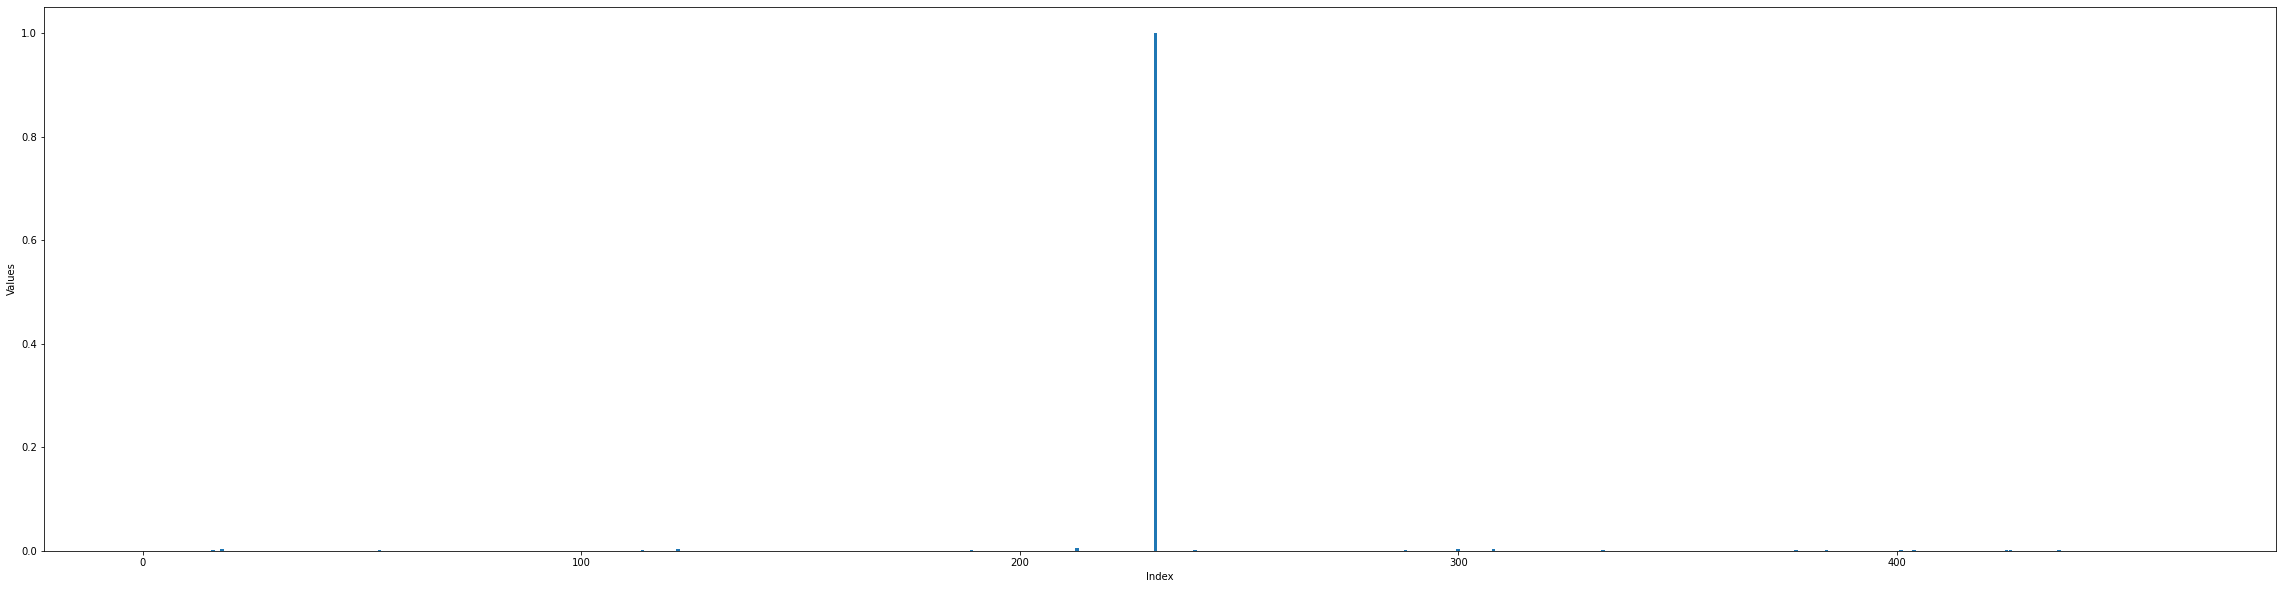

In [ ]:
U_mat = svd.U.rows.map(lambda x : -x[0]).collect()
fig = plt.figure(figsize = (40, 10))
plt.bar(range(1,len(U_mat)+1), U_mat)
plt.xlabel("Index")
plt.ylabel("Values")
plt.show()

In [ ]:
svd.s

DenseVector([789.7159, 522.8027, 410.0372, 360.5112, 338.8066, 305.1706, 301.3668, 296.2558, 292.1242, 261.705, 213.5541, 210.2308, 196.94, 158.738, 151.6689, 142.6693, 138.9256, 131.6705, 125.4737, 120.6082, 116.9641, 113.0618, 110.2742, 107.3361, 102.3115, 99.259, 98.3467, 98.0555, 94.6629, 89.921, 88.2275, 82.8528, 82.1594, 78.8326, 75.448, 73.277, 66.5405, 64.1568, 62.2609, 59.3032, 57.2517, 54.1276, 53.411, 50.8308, 49.6516, 48.1142, 46.5062, 45.0072, 43.951, 42.2166, 40.3062, 36.5017, 36.0275, 34.1166, 33.8108, 33.1469, 31.6249, 31.1009, 30.2418, 28.6915, 28.3014, 27.4938, 27.3293, 25.8713, 24.8826, 24.794, 24.0825, 23.0549, 22.5938, 22.2162, 21.7093, 20.6808, 20.3212, 19.523, 19.2086, 18.6733, 17.6529, 16.936, 16.8004, 16.2052, 15.6342, 15.3458, 14.8709, 14.4176, 13.8294, 13.554, 13.1121, 12.3549, 11.9709, 11.2924, 10.9514, 10.7094, 8.5699, 7.7043, 7.1704, 5.3552, 4.7892, 3.5979, 2.8684, 2.7669])

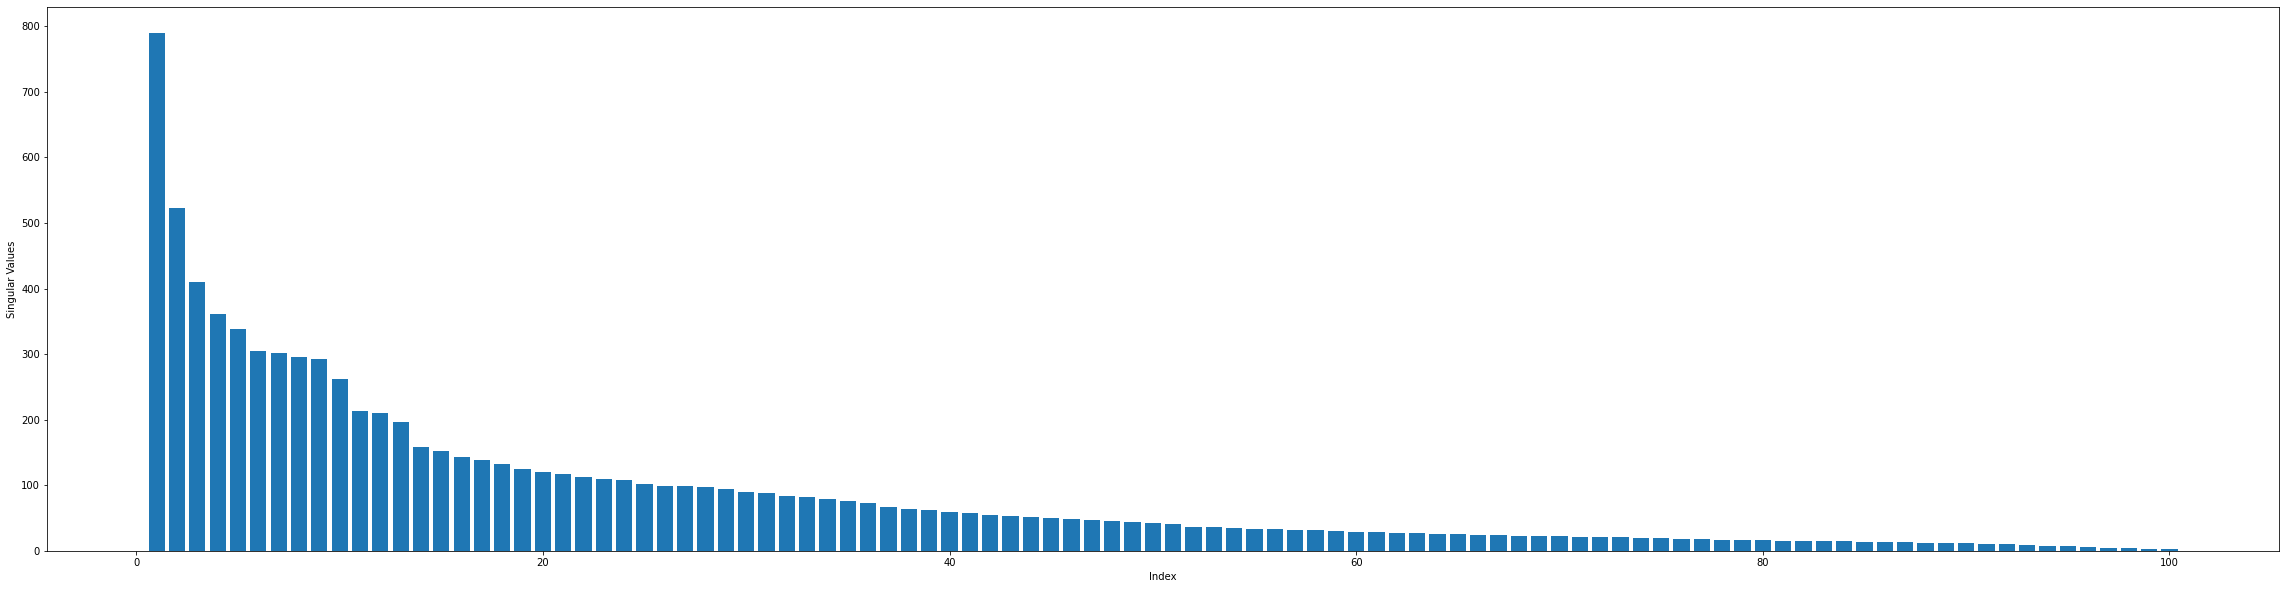

In [ ]:
singular_values = svd.s.values
fig = plt.figure(figsize = (40, 10))
plt.bar(range(1,101), singular_values)
plt.xlabel("Index")
plt.ylabel("Singular Values")
plt.show()

In [ ]:
singular_values[:10].sum()/singular_values.sum()*100

44.59036249070299

In [ ]:
for i in range(100):
    if singular_values[:i].sum()/singular_values.sum()*100 > 80:
        print(i)
        break

36


In [ ]:
V = svd.V
V

DenseMatrix(100, 100, [-0.932, -0.0001, -0.0, -0.0001, -0.0, -0.0016, -0.0002, -0.0001, ..., 0.0011, 0.0019, -0.004, -0.0032, 0.0272, -0.0012, 0.029, -0.0009], 0)

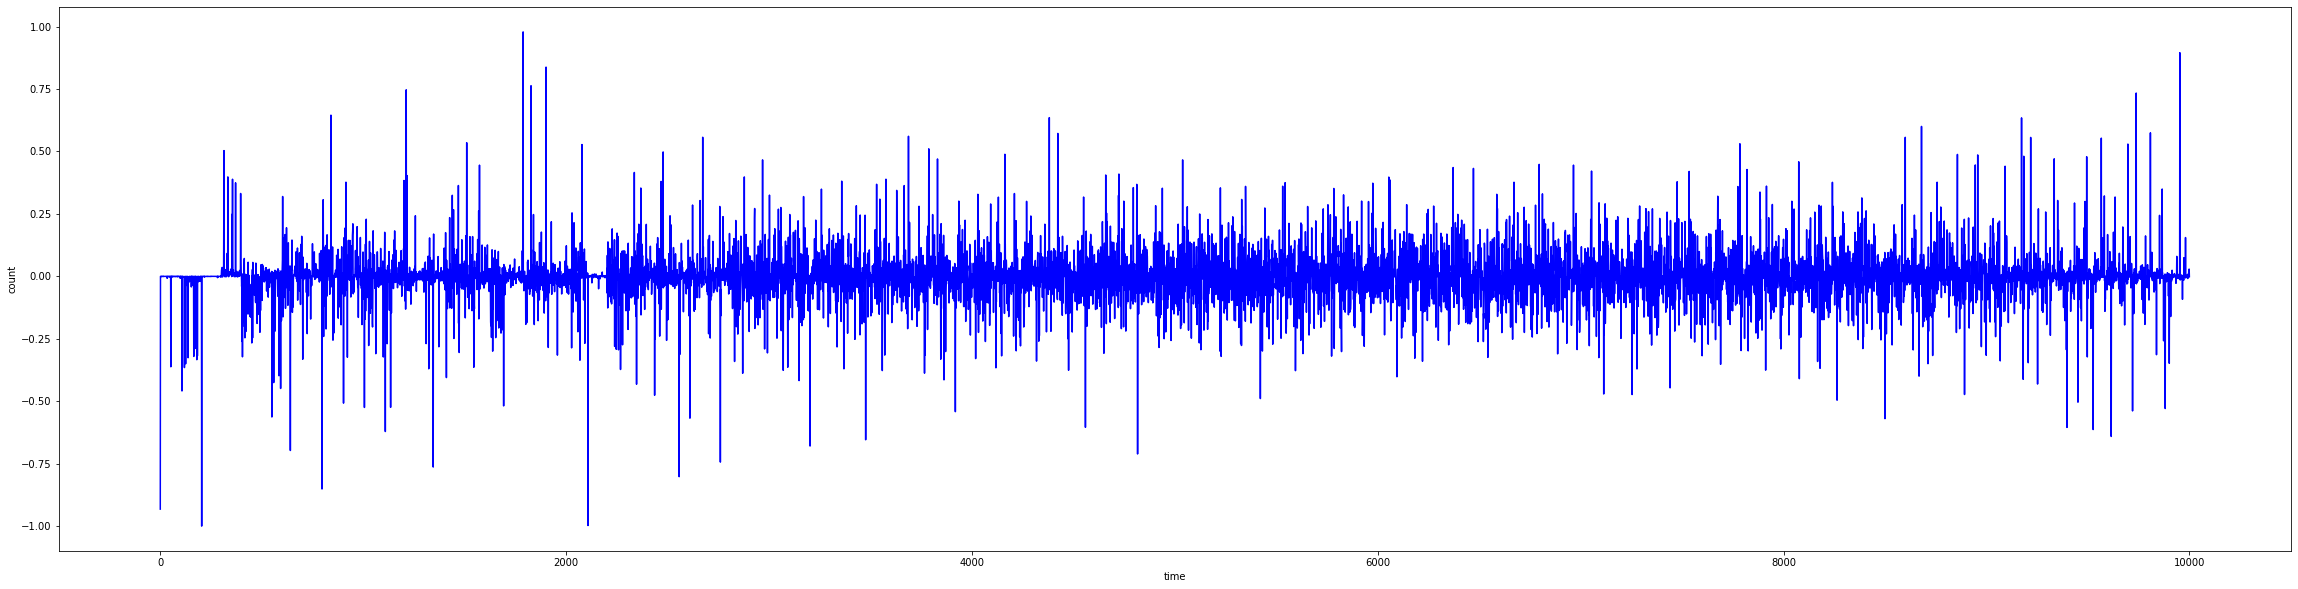

In [ ]:
fig = plt.figure(figsize = (40, 10))
plt.plot(range(1,len(V.values) + 1), V.values, color = 'blue')
plt.ylabel('count')
plt.xlabel('time')

plt.show()

# HITS

In [ ]:
df = df.withColumn('time', (dayofweek(df.PASS_DAY_TIME))*1000 + hour(df.PASS_DAY_TIME))
df = df.groupBy('DEVICE_CODE', 'time').count()
df.show(5)

+-----------+----+-----+
|DEVICE_CODE|time|count|
+-----------+----+-----+
|     205201|2009|  734|
|     631782|2010|   28|
|     900234|5020| 2018|
|     900161|7001|   19|
|     206701|7000|  156|
+-----------+----+-----+
only showing top 5 rows



In [ ]:
# Now it's time to convert it to rdd and create the utility matrix
# Creating the ut matrix
ut = df.rdd.map(lambda x: (x[0], x[1], x[2]))
utility_matrix = CoordinateMatrix(ut)

In [ ]:
svd = utility_matrix.toRowMatrix().computeSVD(1, computeU=True)

In [ ]:
hubs = svd.U.rows.map(lambda x : -x[0]).collect()
hubs = sorted(hubs, reverse = True)
hubs

[0.24993093992839044,
 0.2425260187950847,
 0.21435614196177313,
 0.2049781244891846,
 0.19026982799093042,
 0.18894291340299638,
 0.16360409967349107,
 0.16325094404088203,
 0.15386814416606648,
 0.14964117838676277,
 0.14335616859491385,
 0.1407630788222297,
 0.13688152134675902,
 0.13157324293505332,
 0.1298085543247489,
 0.11967408335367773,
 0.11857904294045915,
 0.11606404977871657,
 0.11447862400138543,
 0.11055861367264937,
 0.11047800489190673,
 0.10348741092430504,
 0.10346356674873611,
 0.101135574949339,
 0.09916222717336132,
 0.09562772117212419,
 0.09532551487296298,
 0.09506022704339644,
 0.09018874153501212,
 0.08994288078939369,
 0.08714464972720501,
 0.08611041203798867,
 0.08363497205015734,
 0.0819430636899393,
 0.0799019968132677,
 0.07984057910621681,
 0.07913750878906245,
 0.07891872478219215,
 0.07757017857888748,
 0.07740753921025706,
 0.07697544418288463,
 0.07516386972050831,
 0.07475496738998513,
 0.07435562147761549,
 0.0728584789251838,
 0.0705510550842938

In [ ]:
# We only need non negative values for authorities
authorities = svd.V.values
lst = []
for val in authorities:
    if val < 0:
        lst.append(-val)
sorted = sorted(lst, reverse =True)
len(lst)

168

In [ ]:
# Now we print the top 10 authorities
sorted[:10]

[0.11711004886658637,
 0.11475652369509887,
 0.11058199357717172,
 0.10858155191282975,
 0.10717513583155577,
 0.10455722668930424,
 0.10449322480852256,
 0.10411680099722698,
 0.10377116117283794,
 0.10376555104962032]

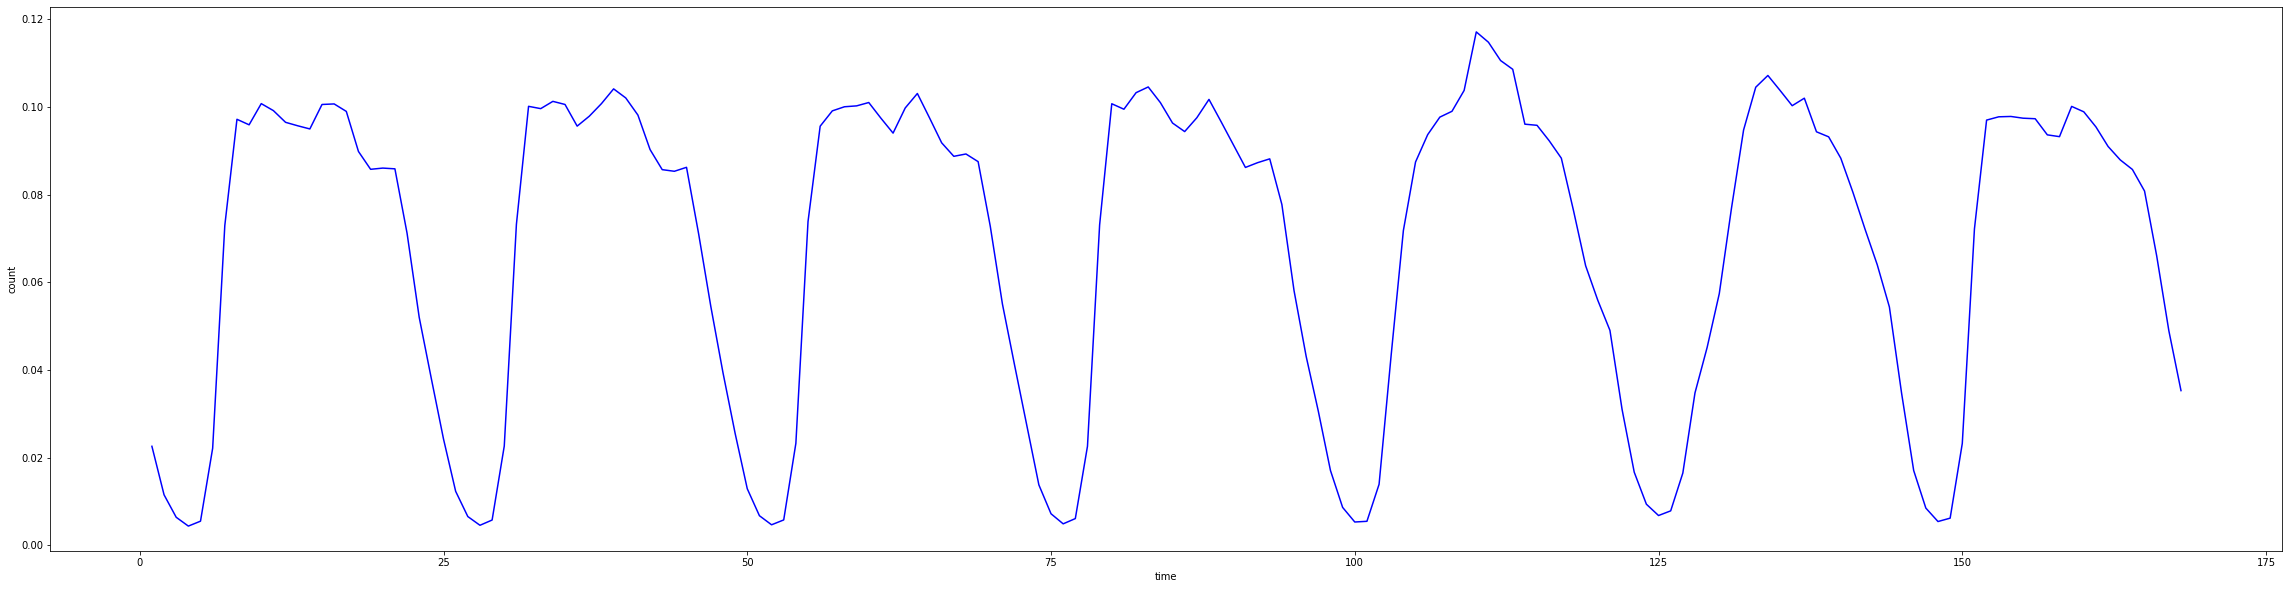

In [ ]:
# Now let's draw the graphs

fig = plt.figure(figsize = (40, 10))
plt.plot(range(1,169), lst, color = 'blue')
plt.ylabel('count')
plt.xlabel('time')

plt.show()

In [ ]:
df=spark.read.csv('/content/drive/My Drive/Test/Data.csv',header=True,schema=schema)
df = df.withColumn('time', (dayofweek(df.PASS_DAY_TIME))*1000 + hour(df.PASS_DAY_TIME))
df = df.withColumn('count', lit(1))



In [ ]:
cnt = df.groupBy("time").sum().orderBy(col("time")).select("sum(count)")
tmp_y = [x[0] for x in cnt.collect()]


In [ ]:
# Now we have to normalize number of rides to be able to compare to the authorities graph
tmp = []
for t in tmp_y:
    tmp.append((t-min(tmp_y))/(max(tmp_y)-min(tmp_y)))
tmp
ls = []
for l in lst:
    ls.append((l-min(lst))/(max(lst)-min(lst)))
ls

[0.16145959211385827,
 0.06332538198725271,
 0.017832678562752453,
 0.0,
 0.009938653634322815,
 0.15750532181545812,
 0.6082192116448483,
 0.8231682272683113,
 0.8120103731078677,
 0.8548992329065419,
 0.8407100966101139,
 0.8170617271501257,
 0.8100646814526574,
 0.8036374557200717,
 0.8531600899684167,
 0.854266074802366,
 0.8391387407333075,
 0.7580518634464639,
 0.7219676811522683,
 0.7244349470985456,
 0.7229430083433455,
 0.5926205060341638,
 0.42240047033675865,
 0.29816854409831095,
 0.17621193984127273,
 0.07034135065233112,
 0.01931330086918126,
 0.0016447006588433386,
 0.012261469282238042,
 0.1618983364316385,
 0.6105954210577356,
 0.8494075598096907,
 0.844744792855209,
 0.8594579160924708,
 0.8531908623554826,
 0.8093612641139251,
 0.8294654815731682,
 0.8549014667476865,
 0.8847209053336043,
 0.8663662217312283,
 0.8317029127719364,
 0.761942174013797,
 0.7212862511580254,
 0.7179746008116292,
 0.7259907529632796,
 0.5909991966537883,
 0.44442667740213726,
 0.3105582783

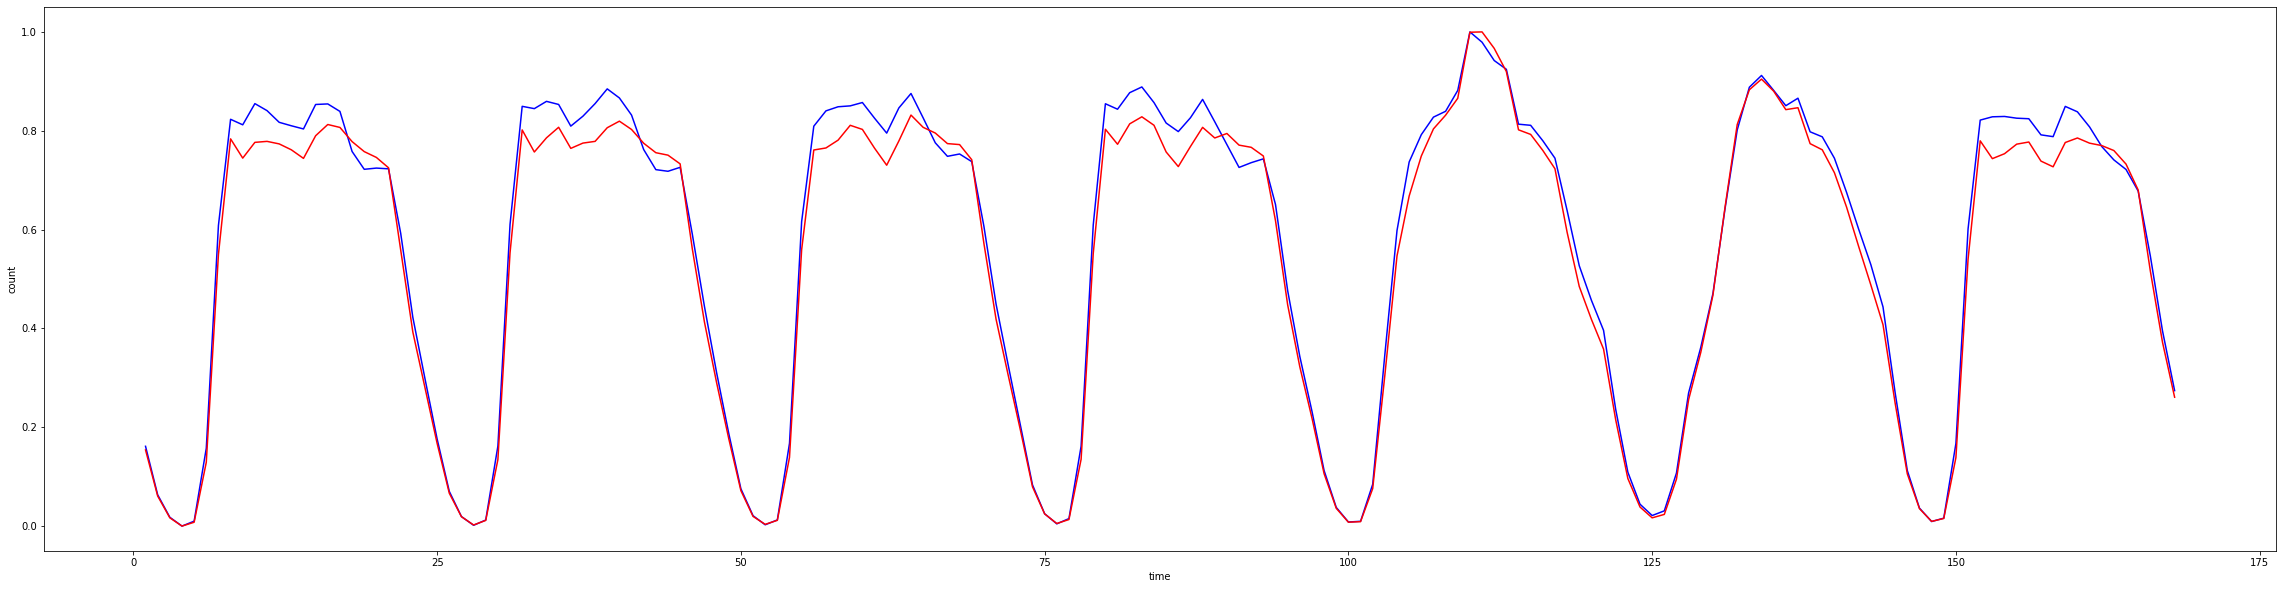

In [ ]:
fig = plt.figure(figsize = (40, 10))
plt.plot(range(1,169), ls, color = 'blue')
plt.plot(range(1,169), tmp, color = 'red')
plt.ylabel('count')
plt.xlabel('time')

plt.show()

# Pixie

In [16]:
# Loading the dataset
df=spark.read.csv('/content/drive/My Drive/Test/Data.csv',header=True,schema=schema)
df = df.filter((col("CHECK_STATUS_KEY") == 5) & (col("FINAL_CAR_KEY") != "null"))
df.show(1)

+-----------+---------+---------------+-------------+----------------+----------+-------------------+
|DEVICE_CODE|SYSTEM_ID|ORIGINE_CAR_KEY|FINAL_CAR_KEY|CHECK_STATUS_KEY|COMPANY_ID|      PASS_DAY_TIME|
+-----------+---------+---------------+-------------+----------------+----------+-------------------+
|     900234|      283|       21757898|     21757898|               5|       264|2022-01-12 20:13:41|
+-----------+---------+---------------+-------------+----------------+----------+-------------------+
only showing top 1 row



In [18]:
# First we create the cars rdd
cars = df.groupBy(col("FINAL_CAR_KEY")).agg(F.collect_list("DEVICE_CODE"))
cars.show(100)

+-------------+-------------------------+
|FINAL_CAR_KEY|collect_list(DEVICE_CODE)|
+-------------+-------------------------+
|     10000007|               [22010053]|
|    100000114|                 [900244]|
|     10000016|                 [900233]|
|    100000353|         [103002, 103002]|
|     10000044|                 [900233]|
|    100000444|                 [900265]|
|     10000048|     [900242, 101301, ...|
|    100000497|     [100700864, 90015...|
|     10000061|     [900256, 900256, ...|
|     10000082|         [631795, 205501]|
|     10000083|     [900117, 900191, ...|
|    100000873|      [900135, 100700862]|
|    100000919|     [22010117, 22010117]|
|     10000101|     [900239, 900191, ...|
|    100001048|                 [631346]|
|     10000111|                 [900191]|
|    100001118|         [631634, 900207]|
|    100001376|                 [900193]|
|     10000144|              [100701303]|
|     10000152|               [22010031]|
|     10000160|     [631361, 163, 

In [ ]:
# Second create the device codes rdd
devs = df.groupBy(col("DEVICE_CODE")).agg(F.collect_list("FINAL_CAR_KEY"))
devs.show(10)َ

+-----------+---------------------------+
|DEVICE_CODE|collect_list(FINAL_CAR_KEY)|
+-----------+---------------------------+
|        101|       [93453738, 958585...|
|        103|       [100309049, 84715...|
|        108|       [90767382, 884245...|
|        111|       [64111706, 468723...|
|        115|       [93717380, 803355...|
|        122|       [100407180, 95838...|
|        126|       [86484689, 877215...|
|        128|       [64111706, 812403...|
|        137|       [95709465, 877229...|
|        140|       [9310631, 8433442...|
+-----------+---------------------------+
only showing top 10 rows



In [ ]:
# Sorting both devs and cars for faster retreival
devs = devs.orderBy(col("DEVICE_CODE"))
cars = cars.orderBy(col("FINAL_CAR_KEY"))
dev_count = devs.count()

In [ ]:
# Now we have to create a lookup table for device codes

dev_array = np.array(devs.select("DEVICE_CODE").collect()).astype(int)
dev_lookup = {}
i = 0
for dev in dev_array:
    dev_lookup[dev[0]] = i
    i += 1
dev_lookup

{100: 0,
 101: 1,
 102: 2,
 103: 3,
 104: 4,
 105: 5,
 106: 6,
 107: 7,
 108: 8,
 109: 9,
 110: 10,
 111: 11,
 112: 12,
 113: 13,
 114: 14,
 115: 15,
 117: 16,
 118: 17,
 119: 18,
 120: 19,
 121: 20,
 122: 21,
 123: 22,
 124: 23,
 125: 24,
 126: 25,
 127: 26,
 128: 27,
 129: 28,
 130: 29,
 134: 30,
 135: 31,
 136: 32,
 137: 33,
 139: 34,
 140: 35,
 141: 36,
 144: 37,
 145: 38,
 146: 39,
 147: 40,
 148: 41,
 149: 42,
 150: 43,
 153: 44,
 154: 45,
 155: 46,
 156: 47,
 157: 48,
 158: 49,
 160: 50,
 161: 51,
 162: 52,
 163: 53,
 164: 54,
 167: 55,
 168: 56,
 169: 57,
 170: 58,
 174: 59,
 175: 60,
 176: 61,
 177: 62,
 231: 63,
 232: 64,
 233: 65,
 101301: 66,
 103001: 67,
 103002: 68,
 107301: 69,
 110220: 70,
 110221: 71,
 200101: 72,
 200202: 73,
 200301: 74,
 200402: 75,
 200501: 76,
 200502: 77,
 200601: 78,
 200701: 79,
 200801: 80,
 200802: 81,
 200901: 82,
 200902: 83,
 201801: 84,
 201901: 85,
 202001: 86,
 202101: 87,
 202201: 88,
 202601: 89,
 202901: 90,
 203001: 91,
 203101: 92,

In [ ]:
# Our main pixie algorithm function, I'll explain more in the report
def pixie(second_df, first_df, steps, alpha, count, starting_query, lookup, first_col, last_col):
    scores = np.zeros(count)
    selected_dev = starting_query
    for i in range(steps):
        print(i)
        # In each step we have to find all edges connected to this particular device code
        first_candidate = first_df.filter(col(f"{first_col}") == int(selected_dev)).select(f"collect_list({last_col})").collect()
        # Then we cast the car candidates to a numpy array and change all entries type to int
        # with help of choice function we can randomly select one car
        new_one = np.random.choice(np.array(first_candidate[0][0]).astype(int),1)[0]
        # Now let's go to another device code that is connected to this particular car
        second_candidate = second_df.filter(col(f"{last_col}") == int(new_one)).select(f"collect_list({first_col})").collect()
        new_dev = np.random.choice(np.array(second_candidate[0][0]).astype(int),1)[0]
        index = lookup[new_dev]
        scores[index] += 1
        selected_dev = new_dev
        rand = random.random()
        if rand < alpha:
            selected_dev = starting_query

    return scores        

In [ ]:
scores = pixie(cars=cars, devs=devs, steps=1000, alpha=0.1, dev_count=dev_count, starting_dev=1001014, dev_lookup=dev_lookup)

In [ ]:
dev_lookup[1001014]

635

In [ ]:
scores 

array([ 1.,  0.,  0.,  1.,  4.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,
        0., 16.,  1.,  4.,  0.,  6.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,
        0.,  2.,  0.,  0.,  0., 10.,  1.,  0.,  0.,  0.,  0.,  0.,  5.,
        0.,  0.,  0.,  1.,  0.,  0.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  2.,  0.,  1.,  0.,  1.,  0.,  0.,  1.,  0.,
        0.,  5.,  3.,  2.,  0.,  0.,  0.,  0.,  0.,  3.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,
        0.,  0.,  0.,  3.,  1.,  0.,  6.,  0.,  0.,  0.,  2.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  8.,  0.,  0.,  0.,
        0.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
        0.,  0.,  0.,  0.,  4.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  4.,  0.,  0.,  0.,  1.,  0.,  0.,
        0.,  1.,  6.,  0.,  0.,  0.,  2.,  0.,  0.,  1.,  0.,  0.,  2.,
        0.,  0.,  1.,  0.,  3.,  0.,  0.,  0.,  0.,  0.,  0.,  0

<BarContainer object of 946 artists>

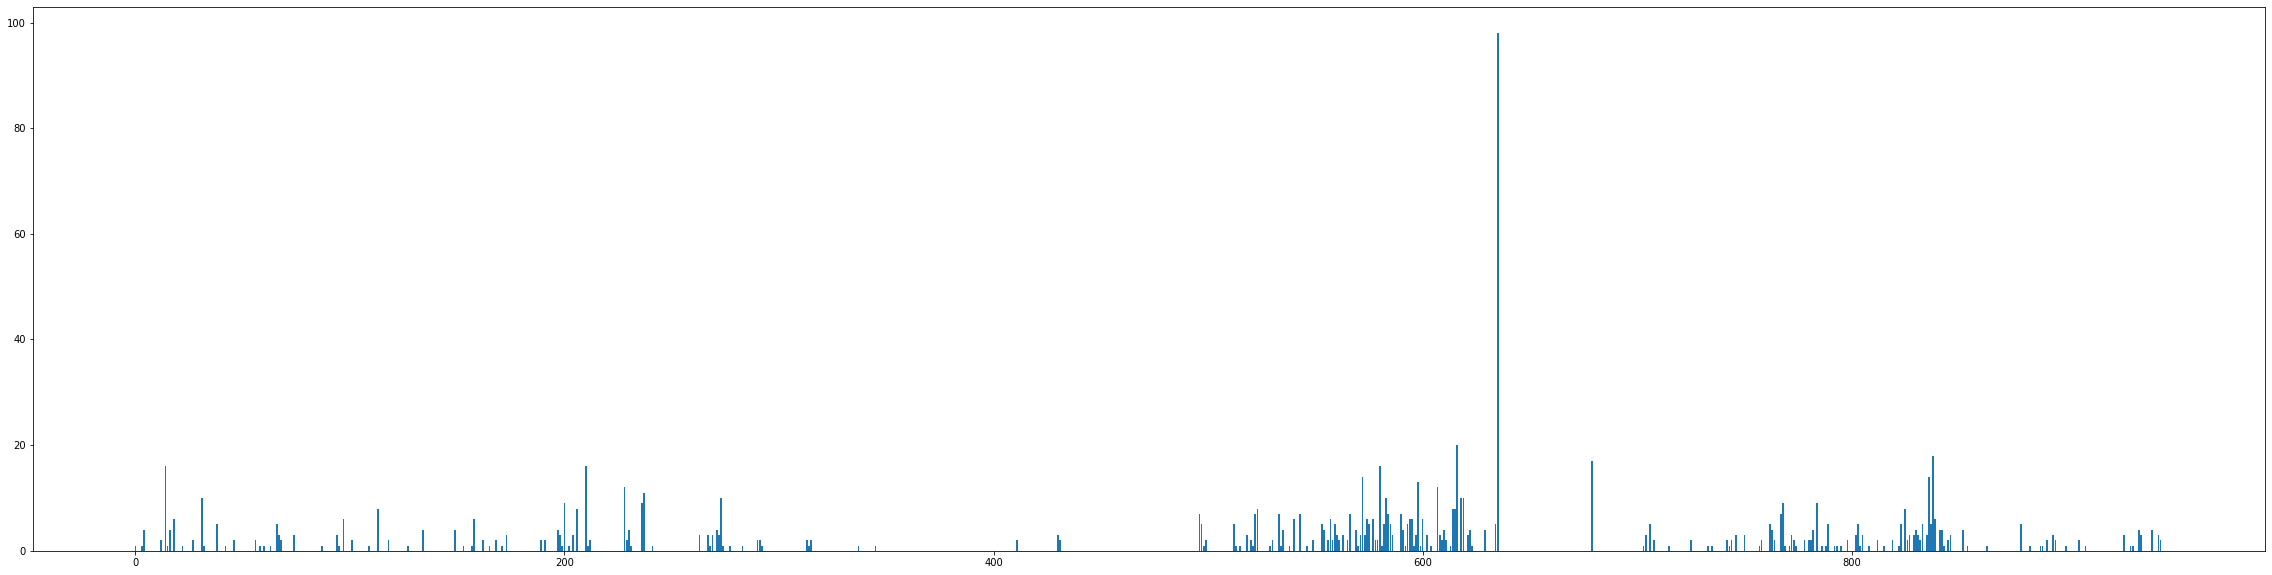

In [ ]:
fig = plt.figure(figsize = (40, 10))
plt.bar(range(len(scores)),scores)

In [ ]:
# Now let's find the most similar ones
sorted_sc = scores
sorted_sc.sort()
# First we have to find the most similar ones value
top_10 = sorted_sc[-10:]

In [ ]:
# Now we have to find indices with respect to these values
top_10_idx = {}
for item in top_10:
    top_10_idx[item] = np.where(scores == item)
top_10_idx

{13.0: (array([598]),),
 14.0: (array([572, 836]),),
 16.0: (array([ 14, 210, 580]),),
 17.0: (array([679]),),
 18.0: (array([838]),),
 20.0: (array([616]),),
 98.0: (array([635]),)}

In [ ]:
# We have to define a function for inverse lookup. 
# Giving it the index and returning the respected device code in dev_lookup dict
def idx_dev(dev_lookup, idx):
    for k in dev_lookup:
        if dev_lookup[k] == idx:
            return k


1001014

In [ ]:
# Let's find real device codes

for key in top_10_idx.keys():
    arr = top_10_idx[key][0]
    lst = []
    for i in range(len(arr)):
        lst.append(idx_dev(dev_lookup, arr[i]))
    top_10_idx[key] = lst
top_10_idx

{13.0: [900244],
 14.0: [900212, 100700841],
 16.0: [114, 631367, 900222],
 17.0: [22000601],
 18.0: [100700853],
 20.0: [900269],
 98.0: [1001014]}

In [ ]:
# Now let's make it a function

def find_similar(score, lookup, num):
    sorted_sc = score.copy()
    sorted_sc.sort()
    top_10 = sorted_sc[-num:]
    top_10_idx = {}
    for item in top_10:
        top_10_idx[int(item)] = np.where(score == item)
    for key in top_10_idx.keys():
        arr = top_10_idx[key][0]
        lst = []
        for i in range(len(arr)):
            lst.append(idx_dev(lookup, arr[i]))
        top_10_idx[key] = lst
    return top_10_idx
find_similar(scores, dev_lookup, 10)

{13: [900244],
 14: [900212, 100700841],
 16: [114, 631367, 900222],
 17: [22000601],
 18: [100700853],
 20: [900269],
 98: [1001014]}

In [ ]:
df_2=spark.read.csv('/content/drive/My Drive/Test/Data.csv',header=True,schema=schema)
df_2 = df_2.withColumn('time', (dayofweek(df_2.PASS_DAY_TIME))*1000 + hour(df_2.PASS_DAY_TIME))

df_2.show(1)

+-----------+---------+---------------+-------------+----------------+----------+-------------------+----+
|DEVICE_CODE|SYSTEM_ID|ORIGINE_CAR_KEY|FINAL_CAR_KEY|CHECK_STATUS_KEY|COMPANY_ID|      PASS_DAY_TIME|time|
+-----------+---------+---------------+-------------+----------------+----------+-------------------+----+
|   22010122|      284|       97955760|     64111706|               7|       161|2022-01-10 08:58:02|2008|
+-----------+---------+---------------+-------------+----------------+----------+-------------------+----+
only showing top 1 row



In [ ]:
# Creating times dataframe based on groupby time column and then aggregating all device codes
times = df_2.groupBy(col("time")).agg(F.collect_list("DEVICE_CODE"))
times.show(10)

+----+-------------------------+
|time|collect_list(DEVICE_CODE)|
+----+-------------------------+
|2007|     [206701, 900266, ...|
|1019|     [100701252, 20580...|
|7005|     [631639, 631639, ...|
|2013|     [900212, 900222, ...|
|5018|     [100700862, 10070...|
|7001|     [100700871, 90023...|
|7008|     [631795, 10070084...|
|7009|     [900164, 900241, ...|
|7006|     [631639, 631639, ...|
|2014|     [100700881, 90025...|
+----+-------------------------+
only showing top 10 rows



In [ ]:
# Device code dataframe aggregating time
devs_time = df_2.groupBy(col("DEVICE_CODE")).agg(F.collect_list("time"))
devs_time.show(10)

+-----------+--------------------+
|DEVICE_CODE|  collect_list(time)|
+-----------+--------------------+
|        101|[7021, 7018, 7021...|
|        103|[7022, 7017, 7020...|
|        107|[7013, 7001, 7013...|
|        108|[7021, 7018, 7022...|
|        111|[7014, 7001, 7014...|
|        112|[7013, 5020, 7014...|
|        115|[7022, 7018, 7021...|
|        117|[7007, 7009, 7008...|
|        120|[7014, 7000, 7013...|
|        122|[7021, 7018, 7021...|
+-----------+--------------------+
only showing top 10 rows



In [ ]:
# Sorting both devs_time and times dataframe
devs_time = devs_time.orderBy(col("DEVICE_CODE"))
times = times.orderBy(col("time"))
times_count = times.count()
times_count

168

In [ ]:
# Now we have to create a lookup table for times
time_array = np.array(times.select("time").collect()).astype(int)
time_lookup = {}
i = 0
for t in time_array:
    time_lookup[t[0]] = i
    i += 1
time_lookup

{1000: 0,
 1001: 1,
 1002: 2,
 1003: 3,
 1004: 4,
 1005: 5,
 1006: 6,
 1007: 7,
 1008: 8,
 1009: 9,
 1010: 10,
 1011: 11,
 1012: 12,
 1013: 13,
 1014: 14,
 1015: 15,
 1016: 16,
 1017: 17,
 1018: 18,
 1019: 19,
 1020: 20,
 1021: 21,
 1022: 22,
 1023: 23,
 2000: 24,
 2001: 25,
 2002: 26,
 2003: 27,
 2004: 28,
 2005: 29,
 2006: 30,
 2007: 31,
 2008: 32,
 2009: 33,
 2010: 34,
 2011: 35,
 2012: 36,
 2013: 37,
 2014: 38,
 2015: 39,
 2016: 40,
 2017: 41,
 2018: 42,
 2019: 43,
 2020: 44,
 2021: 45,
 2022: 46,
 2023: 47,
 3000: 48,
 3001: 49,
 3002: 50,
 3003: 51,
 3004: 52,
 3005: 53,
 3006: 54,
 3007: 55,
 3008: 56,
 3009: 57,
 3010: 58,
 3011: 59,
 3012: 60,
 3013: 61,
 3014: 62,
 3015: 63,
 3016: 64,
 3017: 65,
 3018: 66,
 3019: 67,
 3020: 68,
 3021: 69,
 3022: 70,
 3023: 71,
 4000: 72,
 4001: 73,
 4002: 74,
 4003: 75,
 4004: 76,
 4005: 77,
 4006: 78,
 4007: 79,
 4008: 80,
 4009: 81,
 4010: 82,
 4011: 83,
 4012: 84,
 4013: 85,
 4014: 86,
 4015: 87,
 4016: 88,
 4017: 89,
 4018: 90,
 4019: 91

In [ ]:
sec_scores = pixie(devs_time, times, 1000, 0.2, times_count, 1010,time_lookup, 'time', 'DEVICE_CODE')


In [ ]:
sec_scores

array([ 4.,  2.,  0.,  0.,  0.,  1.,  5.,  9.,  3., 11., 10.,  6.,  4.,
       12., 11.,  5., 11., 12.,  5., 11., 10.,  6.,  5.,  2.,  1.,  0.,
        1.,  1.,  1.,  2.,  7., 10.,  8.,  9., 11.,  8., 10.,  6., 12.,
        6., 15.,  7.,  4., 15.,  4.,  6.,  1.,  2.,  2.,  1.,  3.,  0.,
        0.,  0.,  3.,  8., 10., 10.,  7., 16., 13.,  9., 10.,  8.,  3.,
        6., 10., 11.,  8.,  9.,  4.,  5.,  1.,  0.,  1.,  0.,  1.,  4.,
        4., 10.,  6.,  8.,  7.,  8.,  3.,  8., 14.,  6.,  8., 10.,  5.,
       12.,  4.,  7.,  6.,  2.,  4.,  1.,  0.,  0.,  0.,  0.,  3.,  7.,
        5.,  7.,  7., 11., 10., 10., 10., 11., 11.,  3., 10., 11., 14.,
        4.,  6.,  4.,  3.,  1.,  2.,  1.,  0.,  0.,  0.,  6.,  5.,  6.,
       12.,  7.,  9.,  6.,  9.,  7.,  7., 12.,  6.,  4.,  3.,  4.,  8.,
        2.,  1.,  4.,  0.,  0.,  0.,  1.,  4., 14.,  6., 11.,  8.,  9.,
        6.,  9., 11., 14., 13.,  8.,  6.,  5.,  7.,  1.,  6.,  4.])

<BarContainer object of 168 artists>

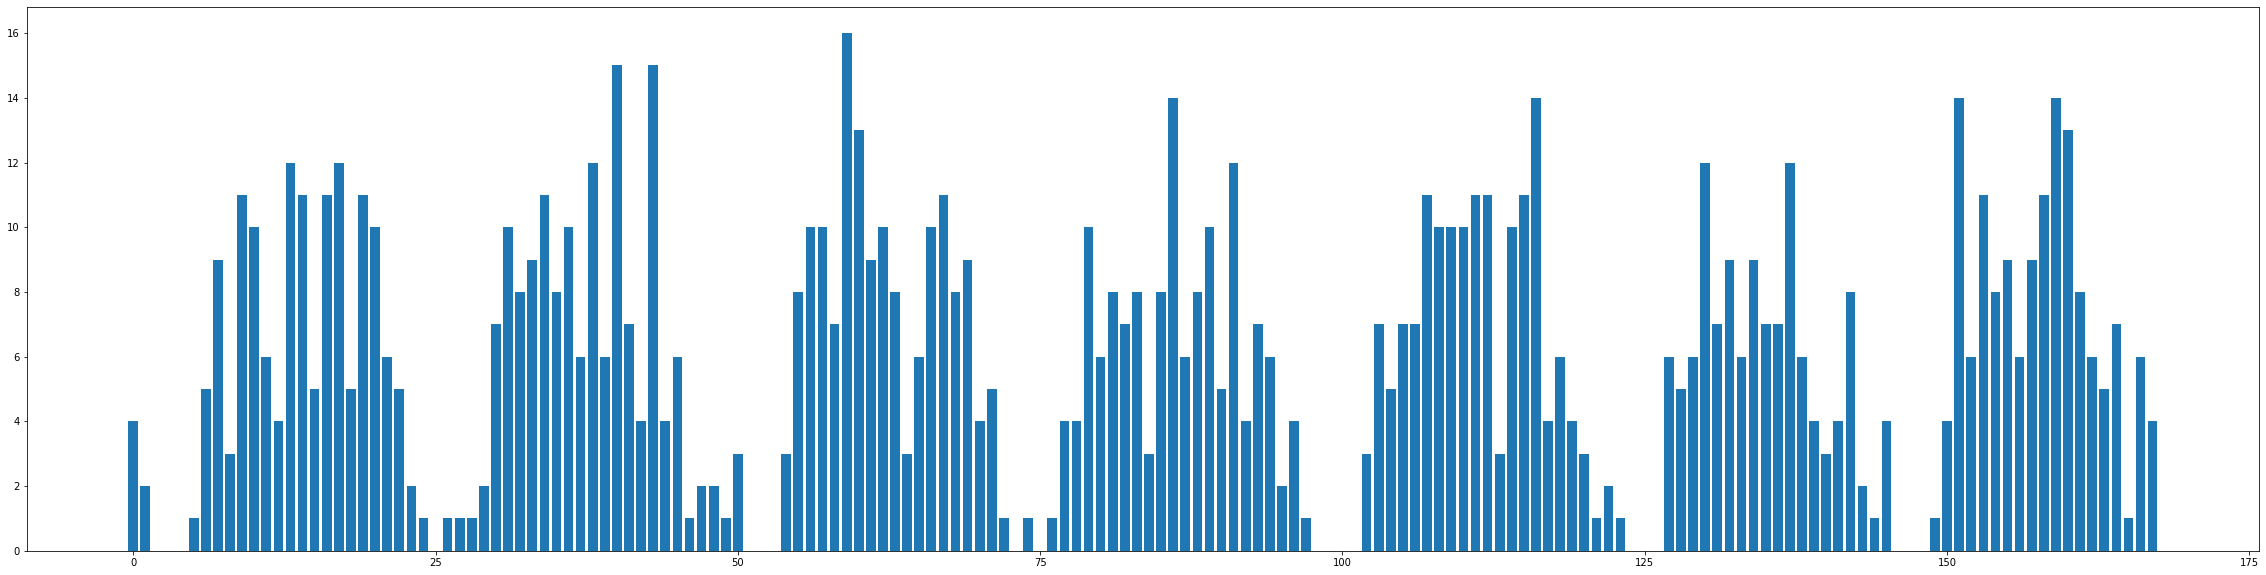

In [ ]:
fig = plt.figure(figsize = (40, 10))
plt.bar(range(len(sec_scores)),sec_scores)

In [ ]:
# Now let's use our similar function to detect the most similar times

find_similar(sec_scores, time_lookup, 100)

{5: [1006, 1015, 1018, 1022, 3023, 4018, 5008, 6008, 7019],
 6: [1011,
  1021,
  2013,
  2015,
  2021,
  3017,
  4008,
  4015,
  4022,
  5022,
  6007,
  6009,
  6013,
  6018,
  7008,
  7012,
  7018,
  7022],
 7: [2006, 2017, 3010, 4010, 4021, 5007, 5009, 5010, 6011, 6015, 6016, 7020],
 8: [2008, 2011, 3007, 3015, 3020, 4009, 4011, 4013, 4016, 6022, 7010, 7017],
 9: [1007, 2009, 3013, 3021, 6012, 6014, 7011, 7013],
 10: [1010,
  1020,
  2007,
  2012,
  3008,
  3009,
  3014,
  3018,
  4007,
  4017,
  5012,
  5013,
  5014,
  5018],
 11: [1009, 1014, 1016, 1019, 2010, 3019, 5011, 5015, 5016, 5019, 7009, 7014],
 12: [1013, 1017, 2014, 4019, 6010, 6017],
 13: [3012, 7016],
 14: [4014, 5020, 7007, 7015],
 15: [2016, 2019],
 16: [3011]}

# Machine Learning

## KMeans

In [ ]:
df_2=spark.read.csv('/content/drive/My Drive/Test/Data.csv',header=True,schema=schema)

df_2 = df_2.withColumn('time', (dayofweek(df_2.PASS_DAY_TIME))*1000 + hour(df_2.PASS_DAY_TIME))

df_2.show(1)

+-----------+---------+---------------+-------------+----------------+----------+-------------------+----+
|DEVICE_CODE|SYSTEM_ID|ORIGINE_CAR_KEY|FINAL_CAR_KEY|CHECK_STATUS_KEY|COMPANY_ID|      PASS_DAY_TIME|time|
+-----------+---------+---------------+-------------+----------------+----------+-------------------+----+
|   22010122|      284|       97955760|     64111706|               7|       161|2022-01-10 08:58:02|2008|
+-----------+---------+---------------+-------------+----------------+----------+-------------------+----+
only showing top 1 row



In [ ]:
time_dev = df_2.groupBy("time", "DEVICE_CODE").count()
time_dev.show(5)

+----+-----------+-----+
|time|DEVICE_CODE|count|
+----+-----------+-----+
|2010|   22010055|  673|
|7001|     900215|  172|
|7000|     631782|   14|
|7006|     900212| 5062|
|7006|   22009972|  994|
+----+-----------+-----+
only showing top 5 rows



In [ ]:

time_dev = time_dev.withColumn("DEVICE_CODE", 
                                  time_dev["DEVICE_CODE"]
                                  .cast('string'))

In [ ]:
from pyspark.ml.feature import StringIndexer
indexer = StringIndexer(inputCol='DEVICE_CODE', outputCol='DEV')
indexer_fitted = indexer.fit(time_dev)
df_indexed = indexer_fitted.transform(time_dev)
df_indexed.show()

+----+-----------+-----+-----+
|time|DEVICE_CODE|count|  DEV|
+----+-----------+-----+-----+
|2010|   22010055|  673|124.0|
|7001|     900215|  172|228.0|
|7000|     631782|   14|286.0|
|7006|     900212| 5062|225.0|
|7006|   22009972|  994|113.0|
|7005|     900241|  176|247.0|
|7006|  100701092|  129| 30.0|
|7005|     631360|    8|322.0|
|7003|     631370|   44|163.0|
|7004|        145|   47| 72.0|
|7003|     202901|   33| 87.0|
|7003|     211401|    6|103.0|
|7007|  100700978|  199| 25.0|
|7003|     631842|    1|506.0|
|7004|  100700929|   11| 19.0|
|7003|  100701045|   12| 26.0|
|7004|  100700919|    1|570.0|
|7002|     680103|    1|635.0|
|7002|     900227|   66|238.0|
|7002|        104|   44| 59.0|
+----+-----------+-----+-----+
only showing top 20 rows



In [ ]:
from pyspark.ml.feature import VectorAssembler
time_dev.columns
assemble=VectorAssembler(inputCols=[
 'time',
 'DEV',
 'count',
], outputCol='features')
assembled_data=assemble.transform(df_indexed)
assembled_data.show(2)


+----+-----------+-----+-----+--------------------+
|time|DEVICE_CODE|count|  DEV|            features|
+----+-----------+-----+-----+--------------------+
|2010|   22010055|  673|124.0|[2010.0,124.0,673.0]|
|7001|     900215|  172|228.0|[7001.0,228.0,172.0]|
+----+-----------+-----+-----+--------------------+
only showing top 2 rows



In [ ]:
from pyspark.ml.feature import StandardScaler
scale=StandardScaler(inputCol='features',outputCol='standardized')
data_scale=scale.fit(assembled_data)
data_scale_output=data_scale.transform(assembled_data)
data_scale_output.show(2)

+----+-----------+-----+-----+--------------------+--------------------+
|time|DEVICE_CODE|count|  DEV|            features|        standardized|
+----+-----------+-----+-----+--------------------+--------------------+
|2010|   22010055|  673|124.0|[2010.0,124.0,673.0]|[1.00739099939041...|
|7001|     900215|  172|228.0|[7001.0,228.0,172.0]|[3.50882805310065...|
+----+-----------+-----+-----+--------------------+--------------------+
only showing top 2 rows



In [ ]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
silhouette_score=[]
evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='standardized', \
                                metricName='silhouette', distanceMeasure='squaredEuclidean')
for i in range(2,10):
    KMeans_algo=KMeans(featuresCol='standardized', k=i)
    KMeans_fit=KMeans_algo.fit(data_scale_output)
    output=KMeans_fit.transform(data_scale_output)
    score=evaluator.evaluate(output)
    silhouette_score.append(score)
    print("Silhouette Score:",score)


Silhouette Score: 0.4016743394501672


Silhouette Score: 0.4576295073109779


Silhouette Score: 0.49365348688011546


Silhouette Score: 0.5026927783680567


Silhouette Score: 0.47758375698728456


Silhouette Score: 0.4430857345356176


Silhouette Score: 0.45355763715870173


Silhouette Score: 0.47809360751964797


In [ ]:
KMeans_algo=KMeans(featuresCol='standardized', k=5)
KMeans_fit=KMeans_algo.fit(data_scale_output)
output=KMeans_fit.transform(data_scale_output)


In [ ]:
output.show(10)

+----+-----------+-----+-----+--------------------+--------------------+----------+
|time|DEVICE_CODE|count|  DEV|            features|        standardized|prediction|
+----+-----------+-----+-----+--------------------+--------------------+----------+
|2010|   22010055|  673|124.0|[2010.0,124.0,673.0]|[1.00739099939041...|         1|
|7001|     900215|  172|228.0|[7001.0,228.0,172.0]|[3.50882805310065...|         0|
|7000|     631782|   14|286.0| [7000.0,286.0,14.0]|[3.50832686354871...|         0|
|7006|     900212| 5062|225.0|[7006.0,225.0,506...|[3.51133400086032...|         3|
|7006|   22009972|  994|113.0|[7006.0,113.0,994.0]|[3.51133400086032...|         0|
|7005|     900241|  176|247.0|[7005.0,247.0,176.0]|[3.51083281130839...|         0|
|7006|  100701092|  129| 30.0| [7006.0,30.0,129.0]|[3.51133400086032...|         0|
|7005|     631360|    8|322.0|  [7005.0,322.0,8.0]|[3.51083281130839...|         0|
|7003|     631370|   44|163.0| [7003.0,163.0,44.0]|[3.50983043220452...|    

In [ ]:
kmeans = output.collect()

## Regression

In [ ]:
splits = data_scale_output.randomSplit([0.7, 0.3])
train_df = splits[0]
test_df = splits[1]

In [ ]:
from pyspark.ml.regression import LinearRegression
# Training Regression model
lr = LinearRegression(featuresCol = 'features', labelCol='count', maxIter=10, regParam=0.3, elasticNetParam=0.8)
lr_model = lr.fit(train_df)
print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))


Coefficients: [0.0,0.0,0.9994933853832367]
Intercept: 0.136217919365616


In [ ]:
trainingSummary = lr_model.summary
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

RMSE: 0.299973
r2: 1.000000


In [ ]:
lr_predictions = lr_model.transform(test_df)
lr_predictions.select("prediction","count","features").show(5)
from pyspark.ml.evaluation import RegressionEvaluator
lr_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="count",metricName="r2")
print("R Squared (R2) on test data = %g" % lr_evaluator.evaluate(lr_predictions))

+------------------+-----+------------------+
|        prediction|count|          features|
+------------------+-----+------------------+
|1.1357113047488527|    1|[1000.0,611.0,1.0]|
|110.08049031152166|  110|[1000.0,6.0,110.0]|
|109.08099692613843|  109|[1000.0,9.0,109.0]|
| 42.11494010546156|   42|[1000.0,17.0,42.0]|
|12.130138543964458|   12|[1000.0,23.0,12.0]|
+------------------+-----+------------------+
only showing top 5 rows



R Squared (R2) on test data = 1


In [ ]:
test_result = lr_model.evaluate(test_df)
print("Root Mean Squared Error (RMSE) on test data = %g" % test_result.rootMeanSquaredError)


Root Mean Squared Error (RMSE) on test data = 0.302862


In [ ]:
predictions = lr_model.transform(test_df)
predictions.select("prediction","count","features").show(100)


+------------------+-----+--------------------+
|        prediction|count|            features|
+------------------+-----+--------------------+
|1.1357113047488527|    1|  [1000.0,611.0,1.0]|
|110.08049031152166|  110|  [1000.0,6.0,110.0]|
|109.08099692613843|  109|  [1000.0,9.0,109.0]|
| 42.11494010546156|   42|  [1000.0,17.0,42.0]|
|12.130138543964458|   12|  [1000.0,23.0,12.0]|
|219.02526931829445|  219| [1000.0,32.0,219.0]|
|12.130138543964458|   12| [1000.0,341.0,12.0]|
|13.129631929347694|   13| [1000.0,342.0,13.0]|
|112.07947708228814|  112| [1000.0,35.0,112.0]|
| 69.10126151080895|   69|  [1000.0,37.0,69.0]|
|13.129631929347694|   13| [1000.0,343.0,13.0]|
|6.1331782316650365|    6|  [1000.0,376.0,6.0]|
| 331.9680218666002|  332| [1000.0,57.0,332.0]|
| 3.134698075515326|    3|  [1000.0,434.0,3.0]|
|2.1352046901320896|    2|  [1000.0,526.0,2.0]|
|22.125072397796824|   22|  [1000.0,71.0,22.0]|
| 55.10835411544363|   55|  [1000.0,76.0,55.0]|
|  92.0896093746234|   92|  [1000.0,78.0